In [1]:
# This is the method that uses the MATLAB Engine API for Python
import matlab.engine
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torchvision import  models, datasets, transforms
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import timm
import pickle
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import numpy as np
import scipy.io as scio
from scipy.io import savemat
import h5py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import gc

In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else 'cpu'

In [3]:
main_channels = scio.loadmat('main_channels_for_autoencoder.mat')
main_channels_mat = main_channels['main_channels']

main_channels_mat = torch.load('main_channels_tensor_for_autoencoder.pt', weights_only=True)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, main_channels_mat):
        # convert into PyTorch tensors and remember them
        self.main_channels_mat = main_channels_mat

    def __len__(self):
        # this should return the size of the dataset
        return len(self.main_channels_mat)
    
    def __getitem__(self, idx):
        # this should return one sample from the dataset
        main_channels_mat = self.main_channels_mat[idx,:,:]
        return main_channels_mat

In [5]:
dataset = CustomDataset(main_channels_mat)

In [6]:
# First, split the dataset into train and remaining (val + test)
train_set, remaining_set = train_test_split(dataset, test_size=40000, random_state=42)

# Now, split the remaining set into validation and test sets
val_set, test_set = train_test_split(remaining_set, test_size=20000, random_state=42)

In [7]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size= batch_size)

In [8]:
batch_main_chan_mat = next(iter(train_loader))

print(f'Shape of batch feature is {batch_main_chan_mat.shape}')
print(f'Data type of batch feature is {batch_main_chan_mat.dtype}')

Shape of batch feature is torch.Size([64, 10, 70])
Data type of batch feature is torch.complex64


In [102]:
class CSIEncoder(nn.Module):
    def __init__(self):
        super(CSIEncoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, stride=1, padding=(1,1))

        self.conv2 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, stride=1, padding=(1,1))

        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(1400, 256)



    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = self.flatten(x2)
        x_encoded = F.sigmoid(self.linear1(x3))
  
        return x_encoded

In [103]:
x_encoded = CSIEncoder()(torch.rand([64,2,10,70]))
x_encoded.shape

torch.Size([64, 256])

### Now we quantize the output

In [104]:
def uniform_quantize(x, bits):
    levels = 2**bits
    quantization_step = levels-1
    quantized_value = round(x*quantization_step)
    return quantized_value

In [105]:
uniform_quantize(0.9,8)

230

In [106]:
def uniform_dequantize(x_quantized, bits):
    levels = 2 ** bits - 1
    x_dequantized = x_quantized / levels  # Scale back
    return x_dequantized

In [107]:
uniform_dequantize(230,8)

0.9019607843137255

In [108]:
class RefineNet(nn.Module):
    def __init__(self):
        super(RefineNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=3, padding=1)

    def forward(self, x_in):
        x = F.relu(self.conv1(x_in))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x + x_in
        return x

In [109]:
x_refined = RefineNet()(torch.rand([64,2,10,70]))
x_refined.shape

torch.Size([64, 2, 10, 70])

In [110]:
class CSIDecoder(nn.Module):
    def __init__(self):
        super(CSIDecoder, self).__init__()

        self.linear1 = nn.Linear(256, 1400)
        
        self.unflatten = nn.Unflatten(1,[2, 10, 70])
        
        self.refine = RefineNet()

        self.conv1 = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = F.sigmoid(self.linear1(x))
        x = self.unflatten(x)
        x = self.refine(x)
        x = self.refine(x)
        x = self.refine(x)
        x = F.sigmoid(x)
        
        return x

In [111]:
class AutoEncode(nn.Module):
    def __init__(self):
        super(AutoEncode, self).__init__()
        
        self.encoder = CSIEncoder()
        self.decoder = CSIDecoder()


    def forward(self, x_enc_input):
        x_enc_output = self.encoder(x_enc_input)
        x = self.decoder(x_enc_output)

        return x

In [112]:
test_input_enc_input = torch.rand([64,2,10,70])
test_output_auto = AutoEncode()(test_input_enc_input)
test_output_auto.shape

torch.Size([64, 2, 10, 70])

In [114]:
def l2_norm_square_loss(input_data, output_data):

    # Separate real and imaginary parts for input and output
    input_real = input_data[:, 0, :, :]  # Real part of input
    input_imag = input_data[:, 1, :, :]  # Imaginary part of input
    output_real = output_data[:, 0, :, :]  # Real part of output
    output_imag = output_data[:, 1, :, :]  # Imaginary part of output

    # Compute L2-norm squared across the last dimension (dim=-1)
    input_l2_norm_squared = torch.sum(input_real**2 + input_imag**2, dim=-1)  # Shape: [batch_size, 10]
    output_l2_norm_squared = torch.sum(output_real**2 + output_imag**2, dim=-1)  # Shape: [batch_size, 10]

    # Compute the loss as the mean squared difference
    l2_loss = torch.mean((input_l2_norm_squared - output_l2_norm_squared)**2)

    return l2_loss

In [115]:
model = AutoEncode().to(device)

# Define the loss functions
loss = torch.nn.MSELoss()  # For classification

# Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)  # Learning rate decay scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=4)

# Variables for early stopping and best parameters
best_loss = float('inf')
best_custom_loss = float('inf')
patience_limit = 20


train_losses = []
val_losses = []


# Train the model
EPOCHS = 100
for epoch in range(EPOCHS):
    running_train_loss = 0.0
    running_train_custom_loss = 0.0
    
    model.train()
    progress_bar_train = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_train:
        # Forward pass
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)
        
        nn_output = model(main_channels_mat_for_nn)

        # Calculate loss
        #initial_loss = loss(nn_output, main_channels_mat_for_nn)
        #train_custom_loss = l2_norm_square_loss(main_channels_mat_for_nn, nn_output)
        #train_loss = initial_loss + 0.01*train_custom_loss

        train_loss = loss(nn_output, main_channels_mat_for_nn)
        
        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Update running loss
        running_train_loss += train_loss.item()
        running_train_custom_loss += train_custom_loss.item()

        
        avg_train_loss = running_train_loss / (index + 1)
        #avg_train_custom_loss = running_train_custom_loss / (index + 1)

        # Get current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']

        # Print metrics
        #progress_bar_train.set_description(f'Epoch [{epoch + 1}/{EPOCHS}] MSELos:{avg_train_loss1:.4f} MSEWeig{mse_weight:.2f} CELos:{avg_train_loss2:.4f} CEWeig{ce_weight:.2f} TrLos:{avg_train_loss:.4f} Tr.Acc: {avg_train_acc*100:.2f}%')
        progress_bar_train.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] T Loss:{avg_train_loss:.4f} LR is {current_lr:.6f}")
    
    #train_losses.append(avg_train_loss)
    train_losses.append(avg_train_loss)

    print(f"Training has completed epoch {epoch+1}")
    
    # Validation loop
    running_val_loss = 0.0
    running_val_custom_loss = 0.0

    
    model.eval()
    progress_bar_val = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_val:
        
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)

        
        with torch.no_grad():
            
            nn_output = model(main_channels_mat_for_nn)

            # Calculate losses
            val_loss = loss(nn_output, main_channels_mat_for_nn)
            #val_custom_loss = l2_norm_square_loss(main_channels_mat_for_nn, nn_output)

            # Update running loss
            running_val_loss += val_loss.item()
            #running_val_custom_loss += val_custom_loss.item()
            
            avg_val_loss = running_val_loss / (index + 1)
            #avg_val_custom_loss = running_val_custom_loss / (index + 1)
            
            progress_bar_val.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] V Loss:{avg_val_loss:.4f}")
    
    #val_losses.append(avg_val_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(running_val_loss)


    # Early stopping
    if avg_val_loss < best_loss:  # Now checking for the best accuracy
        best_loss = avg_val_loss
        #best_custom_loss = avg_val_custom_loss
        best_epoch = epoch + 1
        patience_ = 0
        best_encoder_weights = copy.deepcopy(model.encoder.state_dict())
        best_decoder_weights = copy.deepcopy(model.decoder.state_dict())
        print(f"Best Validation Loss is now: {best_loss:.4f} at Epoch: {best_epoch}")
        #print(f"Best Validation Custom Loss is now: {best_custom_loss:.4f} at Epoch: {best_epoch}")
    else:
        patience_ += 1
        print(f"This is Epoch: {patience_} without improvement")
        print(f"Current Validation Loss is: {avg_val_loss:.4f} at Epoch: {epoch+1}")
        print(f"Best Validation Loss remains: {best_loss:.4f} at Epoch: {best_epoch}")
        #print(f"Current Validation Custom Loss is: {avg_val_custom_loss:.4f} at Epoch: {epoch+1}")
        #print(f"Best Validation Custom Loss remains: {best_custom_loss:.4f} at Epoch: {best_epoch}")
        if patience_ > patience_limit:  # Patience limit before stopping
            print("Early stopping triggered! Restoring best model weights.")
            print(f"Best Validation Loss was: {best_loss:.4f} at Epoch: {best_epoch}")
            #print(f"Best Validation Custom Loss was: {best_custom_loss:.4f} at Epoch: {best_epoch}")
            break



Epoch [1/100] T Loss:1.5901 Cus Loss:59.2812  LR is 0.001000: 100%|█| 2500/2500 [00:23<00:00, 106.9

Training has completed epoch 1



Epoch [1/100] V Loss:0.9965 Custom Loss:43.7511:  63%|██████▎   | 198/313 [00:00<00:00, 211.38it/s]

KeyboardInterrupt: 

In [53]:
model = AutoEncode().to(device)

# Define the loss functions
loss = torch.nn.MSELoss()  # For classification

# Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)  # Learning rate decay scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=4)

# Variables for early stopping and best parameters
best_loss = float('inf')
best_custom_loss = float('inf')
patience_limit = 20


train_losses = []
val_losses = []


# Train the model
EPOCHS = 100
for epoch in range(EPOCHS):
    running_train_loss = 0.0
    running_train_custom_loss = 0.0
    
    model.train()
    progress_bar_train = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_train:
        # Forward pass
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)
        
        nn_output = model(main_channels_mat_for_nn)

        initial_loss = loss(nn_output, main_channels_mat_for_nn)
        train_custom_loss = l2_norm_square_loss(main_channels_mat_for_nn, nn_output)
        # Calculate loss
        
        train_loss = initial_loss + 0.01*train_custom_loss

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Update running loss
        running_train_loss += train_loss.item()
        running_train_custom_loss += train_custom_loss.item()

        
        avg_train_loss = running_train_loss / (index + 1)
        avg_train_custom_loss = running_train_custom_loss / (index + 1)

        # Get current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']

        # Print metrics
        #progress_bar_train.set_description(f'Epoch [{epoch + 1}/{EPOCHS}] MSELos:{avg_train_loss1:.4f} MSEWeig{mse_weight:.2f} CELos:{avg_train_loss2:.4f} CEWeig{ce_weight:.2f} TrLos:{avg_train_loss:.4f} Tr.Acc: {avg_train_acc*100:.2f}%')
        progress_bar_train.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] T Loss:{avg_train_loss:.4f} Cus Loss:{avg_train_custom_loss:.4f}  LR is {current_lr:.6f}")
    
    #train_losses.append(avg_train_loss)
    train_losses.append(avg_train_loss)

    print(f"Training has completed epoch {epoch+1}")
    
    # Validation loop
    running_val_loss = 0.0
    running_val_custom_loss = 0.0

    
    model.eval()
    progress_bar_val = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_val:
        
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)

        
        with torch.no_grad():
            
            nn_output = model(main_channels_mat_for_nn)

            # Calculate losses
            val_loss = loss(nn_output, main_channels_mat_for_nn)
            val_custom_loss = l2_norm_square_loss(main_channels_mat_for_nn, nn_output)

            # Update running loss
            running_val_loss += val_loss.item()
            running_val_custom_loss += val_custom_loss.item()
            
            avg_val_loss = running_val_loss / (index + 1)
            avg_val_custom_loss = running_val_custom_loss / (index + 1)
            
            progress_bar_val.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] V Loss:{avg_val_loss:.4f} Custom Loss:{avg_val_custom_loss:.4f}")
    
    #val_losses.append(avg_val_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(running_val_loss)


    # Early stopping
    if avg_val_loss < best_loss:  # Now checking for the best accuracy
        best_loss = avg_val_loss
        best_custom_loss = avg_val_custom_loss
        best_epoch = epoch + 1
        patience_ = 0
        best_encoder_weights = copy.deepcopy(model.decoder.encoder.state_dict())
        best_decoder_weights = copy.deepcopy(model.decoder.state_dict())
        print(f"Best Validation Loss is now: {best_loss:.4f} at Epoch: {best_epoch}")
        #print(f"Best Validation Custom Loss is now: {best_custom_loss:.4f} at Epoch: {best_epoch}")
    else:
        patience_ += 1
        print(f"This is Epoch: {patience_} without improvement")
        print(f"Current Validation Loss is: {avg_val_loss:.4f} at Epoch: {epoch+1}")
        print(f"Best Validation Loss remains: {best_loss:.4f} at Epoch: {best_epoch}")
        print(f"Current Validation Custom Loss is: {avg_val_custom_loss:.4f} at Epoch: {epoch+1}")
        #print(f"Best Validation Custom Loss remains: {best_custom_loss:.4f} at Epoch: {best_epoch}")
        if patience_ > patience_limit:  # Patience limit before stopping
            print("Early stopping triggered! Restoring best model weights.")
            print(f"Best Validation Loss was: {best_loss:.4f} at Epoch: {best_epoch}")
            #print(f"Best Validation Custom Loss was: {best_custom_loss:.4f} at Epoch: {best_epoch}")
            break



Epoch [1/100] T Loss:1.0499 Cus Loss:23.4769  LR is 0.001000: 100%|█| 2500/2500 [00:34<00:00, 73.06

Training has completed epoch 1



Epoch [1/100] V Loss:0.6263 Custom Loss:12.4375: 100%|██████████| 313/313 [00:02<00:00, 141.88it/s]

Best Validation Loss is now: 0.6263 at Epoch: 1



Epoch [2/100] T Loss:0.6179 Cus Loss:12.3498  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.49

Training has completed epoch 2



Epoch [2/100] V Loss:0.3977 Custom Loss:11.7805: 100%|██████████| 313/313 [00:02<00:00, 155.66it/s]

Best Validation Loss is now: 0.3977 at Epoch: 2



Epoch [3/100] T Loss:0.4715 Cus Loss:11.0453  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.85

Training has completed epoch 3



Epoch [3/100] V Loss:0.3358 Custom Loss:9.8039: 100%|███████████| 313/313 [00:02<00:00, 154.76it/s]

Best Validation Loss is now: 0.3358 at Epoch: 3



Epoch [4/100] T Loss:0.4179 Cus Loss:9.2798  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.42i

Training has completed epoch 4



Epoch [4/100] V Loss:0.3162 Custom Loss:9.7246: 100%|███████████| 313/313 [00:01<00:00, 165.09it/s]

Best Validation Loss is now: 0.3162 at Epoch: 4



Epoch [5/100] T Loss:0.3929 Cus Loss:8.1026  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.81i

Training has completed epoch 5



Epoch [5/100] V Loss:0.3098 Custom Loss:7.0130: 100%|███████████| 313/313 [00:02<00:00, 153.70it/s]

Best Validation Loss is now: 0.3098 at Epoch: 5



Epoch [6/100] T Loss:0.3782 Cus Loss:7.2524  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.54i

Training has completed epoch 6



Epoch [6/100] V Loss:0.3036 Custom Loss:5.8778: 100%|███████████| 313/313 [00:01<00:00, 189.52it/s]

Best Validation Loss is now: 0.3036 at Epoch: 6



Epoch [7/100] T Loss:0.3677 Cus Loss:6.5657  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.87i

Training has completed epoch 7



Epoch [7/100] V Loss:0.3012 Custom Loss:5.7095: 100%|███████████| 313/313 [00:01<00:00, 204.20it/s]

Best Validation Loss is now: 0.3012 at Epoch: 7



Epoch [8/100] T Loss:0.3601 Cus Loss:6.1595  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.33i

Training has completed epoch 8



Epoch [8/100] V Loss:0.2951 Custom Loss:6.4254: 100%|███████████| 313/313 [00:01<00:00, 231.88it/s]

Best Validation Loss is now: 0.2951 at Epoch: 8



Epoch [9/100] T Loss:0.3273 Cus Loss:6.2906  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.45i

Training has completed epoch 9



Epoch [9/100] V Loss:0.2506 Custom Loss:6.4509: 100%|███████████| 313/313 [00:01<00:00, 216.46it/s]

Best Validation Loss is now: 0.2506 at Epoch: 9



Epoch [10/100] T Loss:0.3022 Cus Loss:5.8402  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.58

Training has completed epoch 10



Epoch [10/100] V Loss:0.2395 Custom Loss:5.8972: 100%|██████████| 313/313 [00:01<00:00, 211.60it/s]

Best Validation Loss is now: 0.2395 at Epoch: 10



Epoch [11/100] T Loss:0.2916 Cus Loss:5.3823  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.24

Training has completed epoch 11



Epoch [11/100] V Loss:0.2358 Custom Loss:4.6691: 100%|██████████| 313/313 [00:02<00:00, 134.86it/s]

Best Validation Loss is now: 0.2358 at Epoch: 11



Epoch [12/100] T Loss:0.2852 Cus Loss:5.1036  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.30

Training has completed epoch 12



Epoch [12/100] V Loss:0.2338 Custom Loss:4.1979: 100%|██████████| 313/313 [00:02<00:00, 128.84it/s]

Best Validation Loss is now: 0.2338 at Epoch: 12



Epoch [13/100] T Loss:0.2798 Cus Loss:4.8151  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.94

Training has completed epoch 13



Epoch [13/100] V Loss:0.2317 Custom Loss:4.2916: 100%|██████████| 313/313 [00:02<00:00, 153.60it/s]

Best Validation Loss is now: 0.2317 at Epoch: 13



Epoch [14/100] T Loss:0.2762 Cus Loss:4.6428  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.54

Training has completed epoch 14



Epoch [14/100] V Loss:0.2295 Custom Loss:3.9428: 100%|██████████| 313/313 [00:02<00:00, 144.73it/s]

Best Validation Loss is now: 0.2295 at Epoch: 14



Epoch [15/100] T Loss:0.2729 Cus Loss:4.4629  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.02

Training has completed epoch 15



Epoch [15/100] V Loss:0.2293 Custom Loss:4.0020: 100%|██████████| 313/313 [00:01<00:00, 158.68it/s]

Best Validation Loss is now: 0.2293 at Epoch: 15



Epoch [16/100] T Loss:0.2697 Cus Loss:4.2679  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 78.03

Training has completed epoch 16



Epoch [16/100] V Loss:0.2265 Custom Loss:3.7184: 100%|██████████| 313/313 [00:01<00:00, 158.73it/s]

Best Validation Loss is now: 0.2265 at Epoch: 16



Epoch [17/100] T Loss:0.2676 Cus Loss:4.1628  LR is 0.001000: 100%|█| 2500/2500 [00:34<00:00, 72.20

Training has completed epoch 17



Epoch [17/100] V Loss:0.2245 Custom Loss:4.5650: 100%|██████████| 313/313 [00:01<00:00, 157.70it/s]

Best Validation Loss is now: 0.2245 at Epoch: 17



Epoch [18/100] T Loss:0.2654 Cus Loss:4.0307  LR is 0.001000: 100%|█| 2500/2500 [00:33<00:00, 74.46

Training has completed epoch 18



Epoch [18/100] V Loss:0.2237 Custom Loss:4.3651: 100%|██████████| 313/313 [00:02<00:00, 148.54it/s]

Best Validation Loss is now: 0.2237 at Epoch: 18



Epoch [19/100] T Loss:0.2638 Cus Loss:3.9523  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.85

Training has completed epoch 19



Epoch [19/100] V Loss:0.2249 Custom Loss:3.8358: 100%|██████████| 313/313 [00:02<00:00, 141.83it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2249 at Epoch: 19
Best Validation Loss remains: 0.2237 at Epoch: 18
Current Validation Custom Loss is: 3.8358 at Epoch: 19



Epoch [20/100] T Loss:0.2619 Cus Loss:3.8335  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 76.00

Training has completed epoch 20



Epoch [20/100] V Loss:0.2237 Custom Loss:3.4680: 100%|██████████| 313/313 [00:02<00:00, 144.06it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2237 at Epoch: 20
Best Validation Loss remains: 0.2237 at Epoch: 18
Current Validation Custom Loss is: 3.4680 at Epoch: 20



Epoch [21/100] T Loss:0.2604 Cus Loss:3.7417  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 75.99

Training has completed epoch 21



Epoch [21/100] V Loss:0.2225 Custom Loss:4.0579: 100%|██████████| 313/313 [00:02<00:00, 146.84it/s]

Best Validation Loss is now: 0.2225 at Epoch: 21



Epoch [22/100] T Loss:0.2592 Cus Loss:3.6770  LR is 0.001000: 100%|█| 2500/2500 [00:33<00:00, 75.34

Training has completed epoch 22



Epoch [22/100] V Loss:0.2230 Custom Loss:3.3781: 100%|██████████| 313/313 [00:01<00:00, 172.65it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2230 at Epoch: 22
Best Validation Loss remains: 0.2225 at Epoch: 21
Current Validation Custom Loss is: 3.3781 at Epoch: 22



Epoch [23/100] T Loss:0.2581 Cus Loss:3.6211  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.54

Training has completed epoch 23



Epoch [23/100] V Loss:0.2224 Custom Loss:4.4718: 100%|██████████| 313/313 [00:02<00:00, 145.39it/s]

Best Validation Loss is now: 0.2224 at Epoch: 23



Epoch [24/100] T Loss:0.2563 Cus Loss:3.4918  LR is 0.001000: 100%|█| 2500/2500 [00:33<00:00, 73.86

Training has completed epoch 24



Epoch [24/100] V Loss:0.2216 Custom Loss:3.1851: 100%|██████████| 313/313 [00:01<00:00, 161.13it/s]

Best Validation Loss is now: 0.2216 at Epoch: 24



Epoch [25/100] T Loss:0.2555 Cus Loss:3.4516  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.74

Training has completed epoch 25



Epoch [25/100] V Loss:0.2214 Custom Loss:4.1464: 100%|██████████| 313/313 [00:02<00:00, 132.32it/s]

Best Validation Loss is now: 0.2214 at Epoch: 25



Epoch [26/100] T Loss:0.2547 Cus Loss:3.4016  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 75.88

Training has completed epoch 26



Epoch [26/100] V Loss:0.2208 Custom Loss:3.5093: 100%|██████████| 313/313 [00:02<00:00, 154.86it/s]

Best Validation Loss is now: 0.2208 at Epoch: 26



Epoch [27/100] T Loss:0.2537 Cus Loss:3.3464  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 76.70

Training has completed epoch 27



Epoch [27/100] V Loss:0.2213 Custom Loss:3.6908: 100%|██████████| 313/313 [00:02<00:00, 153.40it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2213 at Epoch: 27
Best Validation Loss remains: 0.2208 at Epoch: 26
Current Validation Custom Loss is: 3.6908 at Epoch: 27



Epoch [28/100] T Loss:0.2530 Cus Loss:3.3053  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 78.09

Training has completed epoch 28



Epoch [28/100] V Loss:0.2198 Custom Loss:3.9629: 100%|██████████| 313/313 [00:01<00:00, 159.76it/s]

Best Validation Loss is now: 0.2198 at Epoch: 28



Epoch [29/100] T Loss:0.2519 Cus Loss:3.2332  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 76.48

Training has completed epoch 29



Epoch [29/100] V Loss:0.2194 Custom Loss:3.4024: 100%|██████████| 313/313 [00:02<00:00, 148.08it/s]

Best Validation Loss is now: 0.2194 at Epoch: 29



Epoch [30/100] T Loss:0.2512 Cus Loss:3.1886  LR is 0.001000: 100%|█| 2500/2500 [00:33<00:00, 75.54

Training has completed epoch 30



Epoch [30/100] V Loss:0.2202 Custom Loss:3.6810: 100%|██████████| 313/313 [00:02<00:00, 135.62it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2202 at Epoch: 30
Best Validation Loss remains: 0.2194 at Epoch: 29
Current Validation Custom Loss is: 3.6810 at Epoch: 30



Epoch [31/100] T Loss:0.2507 Cus Loss:3.1685  LR is 0.001000: 100%|█| 2500/2500 [00:34<00:00, 73.16

Training has completed epoch 31



Epoch [31/100] V Loss:0.2202 Custom Loss:4.6073: 100%|██████████| 313/313 [00:01<00:00, 169.44it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2202 at Epoch: 31
Best Validation Loss remains: 0.2194 at Epoch: 29
Current Validation Custom Loss is: 4.6073 at Epoch: 31



Epoch [32/100] T Loss:0.2496 Cus Loss:3.0868  LR is 0.001000: 100%|█| 2500/2500 [00:33<00:00, 74.78

Training has completed epoch 32



Epoch [32/100] V Loss:0.2188 Custom Loss:3.9030: 100%|██████████| 313/313 [00:02<00:00, 132.49it/s]

Best Validation Loss is now: 0.2188 at Epoch: 32



Epoch [33/100] T Loss:0.2491 Cus Loss:3.0618  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.26

Training has completed epoch 33



Epoch [33/100] V Loss:0.2206 Custom Loss:5.5225: 100%|██████████| 313/313 [00:01<00:00, 173.10it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2206 at Epoch: 33
Best Validation Loss remains: 0.2188 at Epoch: 32
Current Validation Custom Loss is: 5.5225 at Epoch: 33



Epoch [34/100] T Loss:0.2488 Cus Loss:3.0490  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.95

Training has completed epoch 34



Epoch [34/100] V Loss:0.2181 Custom Loss:3.5463: 100%|██████████| 313/313 [00:02<00:00, 135.19it/s]

Best Validation Loss is now: 0.2181 at Epoch: 34



Epoch [35/100] T Loss:0.2358 Cus Loss:3.2920  LR is 0.001000: 100%|█| 2500/2500 [00:35<00:00, 69.99

Training has completed epoch 35



Epoch [35/100] V Loss:0.1665 Custom Loss:3.9519: 100%|██████████| 313/313 [00:01<00:00, 158.70it/s]

Best Validation Loss is now: 0.1665 at Epoch: 35



Epoch [36/100] T Loss:0.1912 Cus Loss:3.5165  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 76.63

Training has completed epoch 36



Epoch [36/100] V Loss:0.1512 Custom Loss:3.7145: 100%|██████████| 313/313 [00:01<00:00, 159.66it/s]

Best Validation Loss is now: 0.1512 at Epoch: 36



Epoch [37/100] T Loss:0.1820 Cus Loss:3.3585  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 76.38

Training has completed epoch 37



Epoch [37/100] V Loss:0.1464 Custom Loss:3.4287: 100%|██████████| 313/313 [00:01<00:00, 174.22it/s]

Best Validation Loss is now: 0.1464 at Epoch: 37



Epoch [38/100] T Loss:0.1778 Cus Loss:3.2364  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.85

Training has completed epoch 38



Epoch [38/100] V Loss:0.1442 Custom Loss:3.2351: 100%|██████████| 313/313 [00:01<00:00, 174.14it/s]

Best Validation Loss is now: 0.1442 at Epoch: 38



Epoch [39/100] T Loss:0.1754 Cus Loss:3.1843  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.09

Training has completed epoch 39



Epoch [39/100] V Loss:0.1431 Custom Loss:3.9329: 100%|██████████| 313/313 [00:02<00:00, 147.40it/s]

Best Validation Loss is now: 0.1431 at Epoch: 39



Epoch [40/100] T Loss:0.1731 Cus Loss:3.0708  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.40

Training has completed epoch 40



Epoch [40/100] V Loss:0.1424 Custom Loss:3.4599: 100%|██████████| 313/313 [00:01<00:00, 160.50it/s]

Best Validation Loss is now: 0.1424 at Epoch: 40



Epoch [41/100] T Loss:0.1719 Cus Loss:3.0352  LR is 0.001000: 100%|█| 2500/2500 [00:33<00:00, 74.48

Training has completed epoch 41



Epoch [41/100] V Loss:0.1419 Custom Loss:3.4146: 100%|██████████| 313/313 [00:01<00:00, 186.39it/s]

Best Validation Loss is now: 0.1419 at Epoch: 41



Epoch [42/100] T Loss:0.1709 Cus Loss:3.0125  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 76.72

Training has completed epoch 42



Epoch [42/100] V Loss:0.1402 Custom Loss:3.1982: 100%|██████████| 313/313 [00:02<00:00, 146.27it/s]

Best Validation Loss is now: 0.1402 at Epoch: 42



Epoch [43/100] T Loss:0.1694 Cus Loss:2.9140  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 75.97

Training has completed epoch 43



Epoch [43/100] V Loss:0.1402 Custom Loss:3.9900: 100%|██████████| 313/313 [00:02<00:00, 138.92it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1402 at Epoch: 43
Best Validation Loss remains: 0.1402 at Epoch: 42
Current Validation Custom Loss is: 3.9900 at Epoch: 43



Epoch [44/100] T Loss:0.1686 Cus Loss:2.8846  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.96

Training has completed epoch 44



Epoch [44/100] V Loss:0.1398 Custom Loss:3.5557: 100%|██████████| 313/313 [00:02<00:00, 153.57it/s]

Best Validation Loss is now: 0.1398 at Epoch: 44



Epoch [45/100] T Loss:0.1677 Cus Loss:2.8307  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.62

Training has completed epoch 45



Epoch [45/100] V Loss:0.1395 Custom Loss:3.2684: 100%|██████████| 313/313 [00:01<00:00, 170.26it/s]

Best Validation Loss is now: 0.1395 at Epoch: 45



Epoch [46/100] T Loss:0.1668 Cus Loss:2.7749  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 75.77

Training has completed epoch 46



Epoch [46/100] V Loss:0.1391 Custom Loss:3.3672: 100%|██████████| 313/313 [00:02<00:00, 147.18it/s]

Best Validation Loss is now: 0.1391 at Epoch: 46



Epoch [47/100] T Loss:0.1659 Cus Loss:2.7177  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.94

Training has completed epoch 47



Epoch [47/100] V Loss:0.1386 Custom Loss:3.1658: 100%|██████████| 313/313 [00:02<00:00, 141.05it/s]

Best Validation Loss is now: 0.1386 at Epoch: 47



Epoch [48/100] T Loss:0.1655 Cus Loss:2.7022  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.37

Training has completed epoch 48



Epoch [48/100] V Loss:0.1385 Custom Loss:3.6328: 100%|██████████| 313/313 [00:02<00:00, 151.38it/s]

Best Validation Loss is now: 0.1385 at Epoch: 48



Epoch [49/100] T Loss:0.1645 Cus Loss:2.6381  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.47

Training has completed epoch 49



Epoch [49/100] V Loss:0.1378 Custom Loss:3.3074: 100%|██████████| 313/313 [00:02<00:00, 142.85it/s]

Best Validation Loss is now: 0.1378 at Epoch: 49



Epoch [50/100] T Loss:0.1644 Cus Loss:2.6438  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.40

Training has completed epoch 50



Epoch [50/100] V Loss:0.1377 Custom Loss:3.1878: 100%|██████████| 313/313 [00:02<00:00, 136.70it/s]

Best Validation Loss is now: 0.1377 at Epoch: 50



Epoch [51/100] T Loss:0.1639 Cus Loss:2.6159  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.71

Training has completed epoch 51



Epoch [51/100] V Loss:0.1375 Custom Loss:3.3253: 100%|██████████| 313/313 [00:02<00:00, 142.95it/s]

Best Validation Loss is now: 0.1375 at Epoch: 51



Epoch [52/100] T Loss:0.1636 Cus Loss:2.6013  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.72

Training has completed epoch 52



Epoch [52/100] V Loss:0.1378 Custom Loss:3.3748: 100%|██████████| 313/313 [00:02<00:00, 136.03it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1378 at Epoch: 52
Best Validation Loss remains: 0.1375 at Epoch: 51
Current Validation Custom Loss is: 3.3748 at Epoch: 52



Epoch [53/100] T Loss:0.1633 Cus Loss:2.5869  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.49

Training has completed epoch 53



Epoch [53/100] V Loss:0.1376 Custom Loss:4.1919: 100%|██████████| 313/313 [00:01<00:00, 164.10it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.1376 at Epoch: 53
Best Validation Loss remains: 0.1375 at Epoch: 51
Current Validation Custom Loss is: 4.1919 at Epoch: 53



Epoch [54/100] T Loss:0.1619 Cus Loss:2.4742  LR is 0.001000: 100%|█| 2500/2500 [00:33<00:00, 75.75

Training has completed epoch 54



Epoch [54/100] V Loss:0.1362 Custom Loss:4.6761: 100%|██████████| 313/313 [00:02<00:00, 130.86it/s]

Best Validation Loss is now: 0.1362 at Epoch: 54



Epoch [55/100] T Loss:0.1628 Cus Loss:2.5735  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.74

Training has completed epoch 55



Epoch [55/100] V Loss:0.1367 Custom Loss:4.1177: 100%|██████████| 313/313 [00:02<00:00, 134.72it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1367 at Epoch: 55
Best Validation Loss remains: 0.1362 at Epoch: 54
Current Validation Custom Loss is: 4.1177 at Epoch: 55



Epoch [56/100] T Loss:0.1617 Cus Loss:2.4815  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.97

Training has completed epoch 56



Epoch [56/100] V Loss:0.1371 Custom Loss:3.4609: 100%|██████████| 313/313 [00:02<00:00, 153.97it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.1371 at Epoch: 56
Best Validation Loss remains: 0.1362 at Epoch: 54
Current Validation Custom Loss is: 3.4609 at Epoch: 56



Epoch [57/100] T Loss:0.1611 Cus Loss:2.4318  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.69

Training has completed epoch 57



Epoch [57/100] V Loss:0.1369 Custom Loss:3.4110: 100%|██████████| 313/313 [00:02<00:00, 145.23it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.1369 at Epoch: 57
Best Validation Loss remains: 0.1362 at Epoch: 54
Current Validation Custom Loss is: 3.4110 at Epoch: 57



Epoch [58/100] T Loss:0.1610 Cus Loss:2.4377  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.44

Training has completed epoch 58



Epoch [58/100] V Loss:0.1362 Custom Loss:3.3650: 100%|██████████| 313/313 [00:01<00:00, 159.58it/s]

Best Validation Loss is now: 0.1362 at Epoch: 58



Epoch [59/100] T Loss:0.1608 Cus Loss:2.4264  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.75

Training has completed epoch 59



Epoch [59/100] V Loss:0.1363 Custom Loss:3.3365: 100%|██████████| 313/313 [00:02<00:00, 138.09it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1363 at Epoch: 59
Best Validation Loss remains: 0.1362 at Epoch: 58
Current Validation Custom Loss is: 3.3365 at Epoch: 59



Epoch [60/100] T Loss:0.1603 Cus Loss:2.3927  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.53

Training has completed epoch 60



Epoch [60/100] V Loss:0.1361 Custom Loss:3.5924: 100%|██████████| 313/313 [00:02<00:00, 148.54it/s]

Best Validation Loss is now: 0.1361 at Epoch: 60



Epoch [61/100] T Loss:0.1599 Cus Loss:2.3596  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.98

Training has completed epoch 61



Epoch [61/100] V Loss:0.1370 Custom Loss:3.5759: 100%|██████████| 313/313 [00:02<00:00, 143.37it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1370 at Epoch: 61
Best Validation Loss remains: 0.1361 at Epoch: 60
Current Validation Custom Loss is: 3.5759 at Epoch: 61



Epoch [62/100] T Loss:0.1596 Cus Loss:2.3509  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.83

Training has completed epoch 62



Epoch [62/100] V Loss:0.1361 Custom Loss:3.2752: 100%|██████████| 313/313 [00:02<00:00, 141.01it/s]

Best Validation Loss is now: 0.1361 at Epoch: 62



Epoch [63/100] T Loss:0.1594 Cus Loss:2.3385  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.00

Training has completed epoch 63



Epoch [63/100] V Loss:0.1360 Custom Loss:3.5294: 100%|██████████| 313/313 [00:02<00:00, 141.82it/s]

Best Validation Loss is now: 0.1360 at Epoch: 63



Epoch [64/100] T Loss:0.1593 Cus Loss:2.3337  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.44

Training has completed epoch 64



Epoch [64/100] V Loss:0.1356 Custom Loss:3.6478: 100%|██████████| 313/313 [00:02<00:00, 154.07it/s]

Best Validation Loss is now: 0.1356 at Epoch: 64



Epoch [65/100] T Loss:0.1592 Cus Loss:2.3294  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.61

Training has completed epoch 65



Epoch [65/100] V Loss:0.1352 Custom Loss:4.6312: 100%|██████████| 313/313 [00:02<00:00, 134.05it/s]

Best Validation Loss is now: 0.1352 at Epoch: 65



Epoch [66/100] T Loss:0.1582 Cus Loss:2.2459  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 76.35

Training has completed epoch 66



Epoch [66/100] V Loss:0.1356 Custom Loss:3.6043: 100%|██████████| 313/313 [00:02<00:00, 140.27it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1356 at Epoch: 66
Best Validation Loss remains: 0.1352 at Epoch: 65
Current Validation Custom Loss is: 3.6043 at Epoch: 66



Epoch [67/100] T Loss:0.1581 Cus Loss:2.2450  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.55

Training has completed epoch 67



Epoch [67/100] V Loss:0.1357 Custom Loss:3.5201: 100%|██████████| 313/313 [00:01<00:00, 167.31it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.1357 at Epoch: 67
Best Validation Loss remains: 0.1352 at Epoch: 65
Current Validation Custom Loss is: 3.5201 at Epoch: 67



Epoch [68/100] T Loss:0.1581 Cus Loss:2.2518  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.06

Training has completed epoch 68



Epoch [68/100] V Loss:0.1354 Custom Loss:3.6780: 100%|██████████| 313/313 [00:02<00:00, 139.75it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.1354 at Epoch: 68
Best Validation Loss remains: 0.1352 at Epoch: 65
Current Validation Custom Loss is: 3.6780 at Epoch: 68



Epoch [69/100] T Loss:0.1574 Cus Loss:2.1942  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.59

Training has completed epoch 69



Epoch [69/100] V Loss:0.1351 Custom Loss:3.3559: 100%|██████████| 313/313 [00:02<00:00, 136.23it/s]

Best Validation Loss is now: 0.1351 at Epoch: 69



Epoch [70/100] T Loss:0.1577 Cus Loss:2.2345  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.00

Training has completed epoch 70



Epoch [70/100] V Loss:0.1356 Custom Loss:3.6534: 100%|██████████| 313/313 [00:02<00:00, 148.26it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1356 at Epoch: 70
Best Validation Loss remains: 0.1351 at Epoch: 69
Current Validation Custom Loss is: 3.6534 at Epoch: 70



Epoch [71/100] T Loss:0.1577 Cus Loss:2.2393  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 76.81

Training has completed epoch 71



Epoch [71/100] V Loss:0.1348 Custom Loss:3.7565: 100%|██████████| 313/313 [00:02<00:00, 146.14it/s]

Best Validation Loss is now: 0.1348 at Epoch: 71



Epoch [72/100] T Loss:0.1573 Cus Loss:2.2042  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.03

Training has completed epoch 72



Epoch [72/100] V Loss:0.1360 Custom Loss:3.5579: 100%|██████████| 313/313 [00:01<00:00, 157.47it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1360 at Epoch: 72
Best Validation Loss remains: 0.1348 at Epoch: 71
Current Validation Custom Loss is: 3.5579 at Epoch: 72



Epoch [73/100] T Loss:0.1572 Cus Loss:2.2038  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.67

Training has completed epoch 73



Epoch [73/100] V Loss:0.1347 Custom Loss:3.4533: 100%|██████████| 313/313 [00:02<00:00, 135.51it/s]

Best Validation Loss is now: 0.1347 at Epoch: 73



Epoch [74/100] T Loss:0.1571 Cus Loss:2.2024  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.28

Training has completed epoch 74



Epoch [74/100] V Loss:0.1345 Custom Loss:3.6991: 100%|██████████| 313/313 [00:02<00:00, 136.68it/s]

Best Validation Loss is now: 0.1345 at Epoch: 74



Epoch [75/100] T Loss:0.1565 Cus Loss:2.1521  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.53

Training has completed epoch 75



Epoch [75/100] V Loss:0.1352 Custom Loss:3.4930: 100%|██████████| 313/313 [00:02<00:00, 141.29it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1352 at Epoch: 75
Best Validation Loss remains: 0.1345 at Epoch: 74
Current Validation Custom Loss is: 3.4930 at Epoch: 75



Epoch [76/100] T Loss:0.1561 Cus Loss:2.1176  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.96

Training has completed epoch 76



Epoch [76/100] V Loss:0.1352 Custom Loss:3.4868: 100%|██████████| 313/313 [00:02<00:00, 142.16it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.1352 at Epoch: 76
Best Validation Loss remains: 0.1345 at Epoch: 74
Current Validation Custom Loss is: 3.4868 at Epoch: 76



Epoch [77/100] T Loss:0.1559 Cus Loss:2.1050  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.60

Training has completed epoch 77



Epoch [77/100] V Loss:0.1351 Custom Loss:3.5549: 100%|██████████| 313/313 [00:02<00:00, 149.57it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.1351 at Epoch: 77
Best Validation Loss remains: 0.1345 at Epoch: 74
Current Validation Custom Loss is: 3.5549 at Epoch: 77



Epoch [78/100] T Loss:0.1561 Cus Loss:2.1308  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.39

Training has completed epoch 78



Epoch [78/100] V Loss:0.1348 Custom Loss:3.6853: 100%|██████████| 313/313 [00:02<00:00, 137.83it/s]

This is Epoch: 4 without improvement
Current Validation Loss is: 0.1348 at Epoch: 78
Best Validation Loss remains: 0.1345 at Epoch: 74
Current Validation Custom Loss is: 3.6853 at Epoch: 78



Epoch [79/100] T Loss:0.1564 Cus Loss:2.1580  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.70

Training has completed epoch 79



Epoch [79/100] V Loss:0.1350 Custom Loss:3.6758: 100%|██████████| 313/313 [00:02<00:00, 138.85it/s]

This is Epoch: 5 without improvement
Current Validation Loss is: 0.1350 at Epoch: 79
Best Validation Loss remains: 0.1345 at Epoch: 74
Current Validation Custom Loss is: 3.6758 at Epoch: 79



Epoch [80/100] T Loss:0.1547 Cus Loss:2.0098  LR is 0.000900: 100%|█| 2500/2500 [00:33<00:00, 75.08

Training has completed epoch 80



Epoch [80/100] V Loss:0.1343 Custom Loss:3.5601: 100%|██████████| 313/313 [00:02<00:00, 137.99it/s]

Best Validation Loss is now: 0.1343 at Epoch: 80



Epoch [81/100] T Loss:0.1548 Cus Loss:2.0224  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 79.07

Training has completed epoch 81



Epoch [81/100] V Loss:0.1347 Custom Loss:3.4777: 100%|██████████| 313/313 [00:02<00:00, 126.32it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1347 at Epoch: 81
Best Validation Loss remains: 0.1343 at Epoch: 80
Current Validation Custom Loss is: 3.4777 at Epoch: 81



Epoch [82/100] T Loss:0.1553 Cus Loss:2.0752  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 78.77

Training has completed epoch 82



Epoch [82/100] V Loss:0.1344 Custom Loss:3.6093: 100%|██████████| 313/313 [00:02<00:00, 150.91it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.1344 at Epoch: 82
Best Validation Loss remains: 0.1343 at Epoch: 80
Current Validation Custom Loss is: 3.6093 at Epoch: 82



Epoch [83/100] T Loss:0.1548 Cus Loss:2.0365  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 79.27

Training has completed epoch 83



Epoch [83/100] V Loss:0.1349 Custom Loss:3.6568: 100%|██████████| 313/313 [00:01<00:00, 160.07it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.1349 at Epoch: 83
Best Validation Loss remains: 0.1343 at Epoch: 80
Current Validation Custom Loss is: 3.6568 at Epoch: 83



Epoch [84/100] T Loss:0.1550 Cus Loss:2.0598  LR is 0.000900: 100%|█| 2500/2500 [00:32<00:00, 76.78

Training has completed epoch 84



Epoch [84/100] V Loss:0.1342 Custom Loss:3.4904: 100%|██████████| 313/313 [00:02<00:00, 147.39it/s]

Best Validation Loss is now: 0.1342 at Epoch: 84



Epoch [85/100] T Loss:0.1546 Cus Loss:2.0200  LR is 0.000900: 100%|█| 2500/2500 [00:32<00:00, 75.93

Training has completed epoch 85



Epoch [85/100] V Loss:0.1343 Custom Loss:3.5405: 100%|██████████| 313/313 [00:02<00:00, 149.39it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1343 at Epoch: 85
Best Validation Loss remains: 0.1342 at Epoch: 84
Current Validation Custom Loss is: 3.5405 at Epoch: 85



Epoch [86/100] T Loss:0.1542 Cus Loss:1.9949  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 78.39

Training has completed epoch 86



Epoch [86/100] V Loss:0.1345 Custom Loss:3.6661: 100%|██████████| 313/313 [00:01<00:00, 157.86it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.1345 at Epoch: 86
Best Validation Loss remains: 0.1342 at Epoch: 84
Current Validation Custom Loss is: 3.6661 at Epoch: 86



Epoch [87/100] T Loss:0.1540 Cus Loss:1.9788  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 78.89

Training has completed epoch 87



Epoch [87/100] V Loss:0.1343 Custom Loss:3.5489: 100%|██████████| 313/313 [00:02<00:00, 148.37it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.1343 at Epoch: 87
Best Validation Loss remains: 0.1342 at Epoch: 84
Current Validation Custom Loss is: 3.5489 at Epoch: 87



Epoch [88/100] T Loss:0.1539 Cus Loss:1.9678  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 80.61

Training has completed epoch 88



Epoch [88/100] V Loss:0.1340 Custom Loss:3.4656: 100%|██████████| 313/313 [00:02<00:00, 149.84it/s]

Best Validation Loss is now: 0.1340 at Epoch: 88



Epoch [89/100] T Loss:0.1537 Cus Loss:1.9533  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 78.63

Training has completed epoch 89



Epoch [89/100] V Loss:0.1340 Custom Loss:3.7301: 100%|██████████| 313/313 [00:01<00:00, 171.31it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1340 at Epoch: 89
Best Validation Loss remains: 0.1340 at Epoch: 88
Current Validation Custom Loss is: 3.7301 at Epoch: 89



Epoch [90/100] T Loss:0.1534 Cus Loss:1.9329  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 79.45

Training has completed epoch 90



Epoch [90/100] V Loss:0.1346 Custom Loss:3.8332: 100%|██████████| 313/313 [00:01<00:00, 157.23it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.1346 at Epoch: 90
Best Validation Loss remains: 0.1340 at Epoch: 88
Current Validation Custom Loss is: 3.8332 at Epoch: 90



Epoch [91/100] T Loss:0.1537 Cus Loss:1.9659  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 78.57

Training has completed epoch 91



Epoch [91/100] V Loss:0.1338 Custom Loss:3.8815: 100%|██████████| 313/313 [00:01<00:00, 194.97it/s]

Best Validation Loss is now: 0.1338 at Epoch: 91



Epoch [92/100] T Loss:0.1530 Cus Loss:1.9049  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 79.32

Training has completed epoch 92



Epoch [92/100] V Loss:0.1346 Custom Loss:3.7909: 100%|██████████| 313/313 [00:01<00:00, 169.07it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1346 at Epoch: 92
Best Validation Loss remains: 0.1338 at Epoch: 91
Current Validation Custom Loss is: 3.7909 at Epoch: 92



Epoch [93/100] T Loss:0.1531 Cus Loss:1.9212  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 79.48

Training has completed epoch 93



Epoch [93/100] V Loss:0.1341 Custom Loss:4.0230: 100%|██████████| 313/313 [00:02<00:00, 151.39it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.1341 at Epoch: 93
Best Validation Loss remains: 0.1338 at Epoch: 91
Current Validation Custom Loss is: 4.0230 at Epoch: 93



Epoch [94/100] T Loss:0.1535 Cus Loss:1.9575  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 79.55

Training has completed epoch 94



Epoch [94/100] V Loss:0.1338 Custom Loss:3.7013: 100%|██████████| 313/313 [00:01<00:00, 163.02it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.1338 at Epoch: 94
Best Validation Loss remains: 0.1338 at Epoch: 91
Current Validation Custom Loss is: 3.7013 at Epoch: 94



Epoch [95/100] T Loss:0.1532 Cus Loss:1.9403  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 78.97

Training has completed epoch 95



Epoch [95/100] V Loss:0.1338 Custom Loss:3.6357: 100%|██████████| 313/313 [00:01<00:00, 159.97it/s]

This is Epoch: 4 without improvement
Current Validation Loss is: 0.1338 at Epoch: 95
Best Validation Loss remains: 0.1338 at Epoch: 91
Current Validation Custom Loss is: 3.6357 at Epoch: 95



Epoch [96/100] T Loss:0.1533 Cus Loss:1.9468  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 79.68

Training has completed epoch 96



Epoch [96/100] V Loss:0.1339 Custom Loss:3.7094: 100%|██████████| 313/313 [00:02<00:00, 137.78it/s]

This is Epoch: 5 without improvement
Current Validation Loss is: 0.1339 at Epoch: 96
Best Validation Loss remains: 0.1338 at Epoch: 91
Current Validation Custom Loss is: 3.7094 at Epoch: 96



Epoch [97/100] T Loss:0.1518 Cus Loss:1.8097  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 79.64

Training has completed epoch 97



Epoch [97/100] V Loss:0.1335 Custom Loss:3.4984: 100%|██████████| 313/313 [00:02<00:00, 152.16it/s]

Best Validation Loss is now: 0.1335 at Epoch: 97



Epoch [98/100] T Loss:0.1523 Cus Loss:1.8601  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.59

Training has completed epoch 98



Epoch [98/100] V Loss:0.1336 Custom Loss:3.5097: 100%|██████████| 313/313 [00:02<00:00, 143.76it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1336 at Epoch: 98
Best Validation Loss remains: 0.1335 at Epoch: 97
Current Validation Custom Loss is: 3.5097 at Epoch: 98



Epoch [99/100] T Loss:0.1519 Cus Loss:1.8302  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 79.29

Training has completed epoch 99



Epoch [99/100] V Loss:0.1329 Custom Loss:3.9477: 100%|██████████| 313/313 [00:02<00:00, 147.55it/s]

Best Validation Loss is now: 0.1329 at Epoch: 99



Epoch [100/100] T Loss:0.1516 Cus Loss:1.8063  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 79.7

Training has completed epoch 100


 Epoch [100/100] V Loss:0.1333 Custom Loss:3.6441: 100%|█████████| 313/313 [00:02<00:00, 145.37it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.1333 at Epoch: 100
Best Validation Loss remains: 0.1329 at Epoch: 99
Current Validation Custom Loss is: 3.6441 at Epoch: 100


In [17]:
model = AutoEncode().to(device)

# Define the loss functions
loss = torch.nn.MSELoss()  # For classification

# Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)  # Learning rate decay scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=4)

# Variables for early stopping and best parameters
best_loss = float('inf')
best_custom_loss = float('inf')
patience_limit = 20


train_losses = []
val_losses = []


# Train the model
EPOCHS = 100
for epoch in range(EPOCHS):
    running_train_loss = 0.0
    running_train_custom_loss = 0.0
    
    model.train()
    progress_bar_train = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_train:
        # Forward pass
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)
        
        nn_output = model(main_channels_mat_for_nn)

        initial_loss = loss(nn_output, main_channels_mat_for_nn)
        train_custom_loss = l2_norm_square_loss(main_channels_mat_for_nn, nn_output)
        # Calculate loss
        
        train_loss = initial_loss + 0.01*train_custom_loss

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Update running loss
        running_train_loss += train_loss.item()
        running_train_custom_loss += train_custom_loss.item()

        
        avg_train_loss = running_train_loss / (index + 1)
        avg_train_custom_loss = running_train_custom_loss / (index + 1)

        # Get current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']

        # Print metrics
        #progress_bar_train.set_description(f'Epoch [{epoch + 1}/{EPOCHS}] MSELos:{avg_train_loss1:.4f} MSEWeig{mse_weight:.2f} CELos:{avg_train_loss2:.4f} CEWeig{ce_weight:.2f} TrLos:{avg_train_loss:.4f} Tr.Acc: {avg_train_acc*100:.2f}%')
        progress_bar_train.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] T Loss:{avg_train_loss:.4f} Cus Loss:{avg_train_custom_loss:.4f}  LR is {current_lr:.6f}")
    
    #train_losses.append(avg_train_loss)
    train_losses.append(avg_train_loss)

    print(f"Training has completed epoch {epoch+1}")
    
    # Validation loop
    running_val_loss = 0.0
    running_val_custom_loss = 0.0

    
    model.eval()
    progress_bar_val = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_val:
        
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)

        
        with torch.no_grad():
            
            nn_output = model(main_channels_mat_for_nn)

            # Calculate losses
            val_loss = loss(nn_output, main_channels_mat_for_nn)
            val_custom_loss = l2_norm_square_loss(main_channels_mat_for_nn, nn_output)

            # Update running loss
            running_val_loss += val_loss.item()
            running_val_custom_loss += val_custom_loss.item()
            
            avg_val_loss = running_val_loss / (index + 1)
            avg_val_custom_loss = running_val_custom_loss / (index + 1)
            
            progress_bar_val.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] V Loss:{avg_val_loss:.4f} Custom Loss:{avg_val_custom_loss:.4f}")
    
    #val_losses.append(avg_val_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(running_val_loss)


    # Early stopping
    if avg_val_loss < best_loss:  # Now checking for the best accuracy
        best_loss = avg_val_loss
        best_custom_loss = avg_val_custom_loss
        best_epoch = epoch + 1
        patience_ = 0
        best_encoder_weights = copy.deepcopy(model.decoder.encoder.state_dict())
        best_decoder_weights = copy.deepcopy(model.decoder.state_dict())
        print(f"Best Validation Loss is now: {best_loss:.4f} at Epoch: {best_epoch}")
        #print(f"Best Validation Custom Loss is now: {best_custom_loss:.4f} at Epoch: {best_epoch}")
    else:
        patience_ += 1
        print(f"This is Epoch: {patience_} without improvement")
        print(f"Current Validation Loss is: {avg_val_loss:.4f} at Epoch: {epoch+1}")
        print(f"Best Validation Loss remains: {best_loss:.4f} at Epoch: {best_epoch}")
        print(f"Current Validation Custom Loss is: {avg_val_custom_loss:.4f} at Epoch: {epoch+1}")
        #print(f"Best Validation Custom Loss remains: {best_custom_loss:.4f} at Epoch: {best_epoch}")
        if patience_ > patience_limit:  # Patience limit before stopping
            print("Early stopping triggered! Restoring best model weights.")
            print(f"Best Validation Loss was: {best_loss:.4f} at Epoch: {best_epoch}")
            #print(f"Best Validation Custom Loss was: {best_custom_loss:.4f} at Epoch: {best_epoch}")
            break



Epoch [1/100] T Loss:1.0048 Cus Loss:29.4704  LR is 0.001000: 100%|█| 2500/2500 [00:34<00:00, 71.45

Training has completed epoch 1



Epoch [1/100] V Loss:0.4206 Custom Loss:11.0617: 100%|██████████| 313/313 [00:02<00:00, 141.34it/s]

Best Validation Custom Loss is now: 11.0617 at Epoch: 1



Epoch [2/100] T Loss:0.4204 Cus Loss:10.1541  LR is 0.001000: 100%|█| 2500/2500 [00:35<00:00, 70.75

Training has completed epoch 2



Epoch [2/100] V Loss:0.2800 Custom Loss:8.0904: 100%|███████████| 313/313 [00:01<00:00, 202.81it/s]

Best Validation Custom Loss is now: 8.0904 at Epoch: 2



Epoch [3/100] T Loss:0.3444 Cus Loss:7.7903  LR is 0.001000: 100%|█| 2500/2500 [00:33<00:00, 75.42i

Training has completed epoch 3



Epoch [3/100] V Loss:0.2566 Custom Loss:7.5358: 100%|███████████| 313/313 [00:01<00:00, 177.82it/s]

Best Validation Custom Loss is now: 7.5358 at Epoch: 3



Epoch [4/100] T Loss:0.3202 Cus Loss:6.7185  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 75.91i

Training has completed epoch 4



Epoch [4/100] V Loss:0.2491 Custom Loss:6.3043: 100%|███████████| 313/313 [00:01<00:00, 164.14it/s]

Best Validation Custom Loss is now: 6.3043 at Epoch: 4



Epoch [5/100] T Loss:0.3080 Cus Loss:6.1083  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 76.60i

Training has completed epoch 5



Epoch [5/100] V Loss:0.2433 Custom Loss:6.5663: 100%|███████████| 313/313 [00:01<00:00, 170.65it/s]

Best Validation Custom Loss is now: 6.5663 at Epoch: 5



Epoch [6/100] T Loss:0.2994 Cus Loss:5.6411  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.75i

Training has completed epoch 6



Epoch [6/100] V Loss:0.2425 Custom Loss:5.0653: 100%|███████████| 313/313 [00:01<00:00, 173.37it/s]

Best Validation Custom Loss is now: 5.0653 at Epoch: 6



Epoch [7/100] T Loss:0.2934 Cus Loss:5.3368  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.61i

Training has completed epoch 7



Epoch [7/100] V Loss:0.2378 Custom Loss:5.3124: 100%|███████████| 313/313 [00:01<00:00, 159.53it/s]

Best Validation Custom Loss is now: 5.3124 at Epoch: 7



Epoch [8/100] T Loss:0.2884 Cus Loss:5.0782  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.77i

Training has completed epoch 8



Epoch [8/100] V Loss:0.2357 Custom Loss:4.9789: 100%|███████████| 313/313 [00:01<00:00, 157.10it/s]

Best Validation Custom Loss is now: 4.9789 at Epoch: 8



Epoch [9/100] T Loss:0.2846 Cus Loss:4.9046  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.81i

Training has completed epoch 9



Epoch [9/100] V Loss:0.2367 Custom Loss:4.6838: 100%|███████████| 313/313 [00:01<00:00, 169.20it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2367 at Epoch: 9
Best Validation Loss remains: 0.2357 at Epoch: 8
Current Validation Custom Loss is: 4.6838 at Epoch: 9



Epoch [10/100] T Loss:0.2801 Cus Loss:4.6478  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.31

Training has completed epoch 10



Epoch [10/100] V Loss:0.2328 Custom Loss:3.8318: 100%|██████████| 313/313 [00:01<00:00, 193.30it/s]

Best Validation Custom Loss is now: 3.8318 at Epoch: 10



Epoch [11/100] T Loss:0.2777 Cus Loss:4.5620  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.17

Training has completed epoch 11



Epoch [11/100] V Loss:0.2338 Custom Loss:5.5744: 100%|██████████| 313/313 [00:02<00:00, 110.29it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2338 at Epoch: 11
Best Validation Loss remains: 0.2328 at Epoch: 10
Current Validation Custom Loss is: 5.5744 at Epoch: 11



Epoch [12/100] T Loss:0.2749 Cus Loss:4.4124  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 78.09

Training has completed epoch 12



Epoch [12/100] V Loss:0.2297 Custom Loss:4.3653: 100%|██████████| 313/313 [00:01<00:00, 170.25it/s]

Best Validation Custom Loss is now: 4.3653 at Epoch: 12



Epoch [13/100] T Loss:0.2728 Cus Loss:4.3066  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 81.74

Training has completed epoch 13



Epoch [13/100] V Loss:0.2301 Custom Loss:4.3467: 100%|██████████| 313/313 [00:01<00:00, 158.20it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2301 at Epoch: 13
Best Validation Loss remains: 0.2297 at Epoch: 12
Current Validation Custom Loss is: 4.3467 at Epoch: 13



Epoch [14/100] T Loss:0.2706 Cus Loss:4.1855  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 82.85

Training has completed epoch 14



Epoch [14/100] V Loss:0.2272 Custom Loss:3.9348: 100%|██████████| 313/313 [00:01<00:00, 163.62it/s]

Best Validation Custom Loss is now: 3.9348 at Epoch: 14



Epoch [15/100] T Loss:0.2684 Cus Loss:4.0576  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 82.28

Training has completed epoch 15



Epoch [15/100] V Loss:0.2296 Custom Loss:5.0666: 100%|██████████| 313/313 [00:01<00:00, 168.07it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2296 at Epoch: 15
Best Validation Loss remains: 0.2272 at Epoch: 14
Current Validation Custom Loss is: 5.0666 at Epoch: 15



Epoch [16/100] T Loss:0.2673 Cus Loss:4.0150  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.42

Training has completed epoch 16



Epoch [16/100] V Loss:0.2287 Custom Loss:4.9534: 100%|██████████| 313/313 [00:01<00:00, 187.12it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2287 at Epoch: 16
Best Validation Loss remains: 0.2272 at Epoch: 14
Current Validation Custom Loss is: 4.9534 at Epoch: 16



Epoch [17/100] T Loss:0.2658 Cus Loss:3.9289  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 80.82

Training has completed epoch 17



Epoch [17/100] V Loss:0.2265 Custom Loss:4.6792: 100%|██████████| 313/313 [00:02<00:00, 154.44it/s]

Best Validation Custom Loss is now: 4.6792 at Epoch: 17



Epoch [18/100] T Loss:0.2645 Cus Loss:3.8622  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.89

Training has completed epoch 18



Epoch [18/100] V Loss:0.2255 Custom Loss:3.3051: 100%|██████████| 313/313 [00:02<00:00, 145.66it/s]

Best Validation Custom Loss is now: 3.3051 at Epoch: 18



Epoch [19/100] T Loss:0.2633 Cus Loss:3.7988  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.93

Training has completed epoch 19



Epoch [19/100] V Loss:0.2247 Custom Loss:3.5660: 100%|██████████| 313/313 [00:01<00:00, 160.81it/s]

Best Validation Custom Loss is now: 3.5660 at Epoch: 19



Epoch [20/100] T Loss:0.2624 Cus Loss:3.7512  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 79.46

Training has completed epoch 20



Epoch [20/100] V Loss:0.2241 Custom Loss:3.9491: 100%|██████████| 313/313 [00:01<00:00, 163.13it/s]

Best Validation Custom Loss is now: 3.9491 at Epoch: 20



Epoch [21/100] T Loss:0.2614 Cus Loss:3.6976  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 78.04

Training has completed epoch 21



Epoch [21/100] V Loss:0.2250 Custom Loss:3.9697: 100%|██████████| 313/313 [00:01<00:00, 175.26it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2250 at Epoch: 21
Best Validation Loss remains: 0.2241 at Epoch: 20
Current Validation Custom Loss is: 3.9697 at Epoch: 21



Epoch [22/100] T Loss:0.2607 Cus Loss:3.6716  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 81.81

Training has completed epoch 22



Epoch [22/100] V Loss:0.2246 Custom Loss:3.4295: 100%|██████████| 313/313 [00:01<00:00, 175.49it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2246 at Epoch: 22
Best Validation Loss remains: 0.2241 at Epoch: 20
Current Validation Custom Loss is: 3.4295 at Epoch: 22



Epoch [23/100] T Loss:0.2597 Cus Loss:3.6137  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.22

Training has completed epoch 23



Epoch [23/100] V Loss:0.2228 Custom Loss:3.6289: 100%|██████████| 313/313 [00:02<00:00, 145.48it/s]

Best Validation Custom Loss is now: 3.6289 at Epoch: 23



Epoch [24/100] T Loss:0.2589 Cus Loss:3.5706  LR is 0.001000: 100%|█| 2500/2500 [00:32<00:00, 77.33

Training has completed epoch 24



Epoch [24/100] V Loss:0.2226 Custom Loss:3.4730: 100%|██████████| 313/313 [00:01<00:00, 162.69it/s]

Best Validation Custom Loss is now: 3.4730 at Epoch: 24



Epoch [25/100] T Loss:0.2584 Cus Loss:3.5488  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.44

Training has completed epoch 25



Epoch [25/100] V Loss:0.2219 Custom Loss:4.1553: 100%|██████████| 313/313 [00:02<00:00, 141.13it/s]

Best Validation Custom Loss is now: 4.1553 at Epoch: 25



Epoch [26/100] T Loss:0.2577 Cus Loss:3.5113  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 81.77

Training has completed epoch 26



Epoch [26/100] V Loss:0.2227 Custom Loss:3.5188: 100%|██████████| 313/313 [00:02<00:00, 144.83it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2227 at Epoch: 26
Best Validation Loss remains: 0.2219 at Epoch: 25
Current Validation Custom Loss is: 3.5188 at Epoch: 26



Epoch [27/100] T Loss:0.2569 Cus Loss:3.4640  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 81.86

Training has completed epoch 27



Epoch [27/100] V Loss:0.2225 Custom Loss:2.9636: 100%|██████████| 313/313 [00:02<00:00, 152.36it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2225 at Epoch: 27
Best Validation Loss remains: 0.2219 at Epoch: 25
Current Validation Custom Loss is: 2.9636 at Epoch: 27



Epoch [28/100] T Loss:0.2563 Cus Loss:3.4305  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 78.71

Training has completed epoch 28



Epoch [28/100] V Loss:0.2229 Custom Loss:3.4158: 100%|██████████| 313/313 [00:01<00:00, 161.02it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.2229 at Epoch: 28
Best Validation Loss remains: 0.2219 at Epoch: 25
Current Validation Custom Loss is: 3.4158 at Epoch: 28



Epoch [29/100] T Loss:0.2560 Cus Loss:3.4304  LR is 0.001000: 100%|█| 2500/2500 [00:31<00:00, 80.05

Training has completed epoch 29



Epoch [29/100] V Loss:0.2194 Custom Loss:4.9664: 100%|██████████| 313/313 [00:02<00:00, 144.90it/s]

Best Validation Custom Loss is now: 4.9664 at Epoch: 29



Epoch [30/100] T Loss:0.2556 Cus Loss:3.4163  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 82.18

Training has completed epoch 30



Epoch [30/100] V Loss:0.2225 Custom Loss:3.3573: 100%|██████████| 313/313 [00:01<00:00, 163.01it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2225 at Epoch: 30
Best Validation Loss remains: 0.2194 at Epoch: 29
Current Validation Custom Loss is: 3.3573 at Epoch: 30



Epoch [31/100] T Loss:0.2546 Cus Loss:3.3484  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 82.08

Training has completed epoch 31



Epoch [31/100] V Loss:0.2219 Custom Loss:4.1371: 100%|██████████| 313/313 [00:01<00:00, 164.67it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2219 at Epoch: 31
Best Validation Loss remains: 0.2194 at Epoch: 29
Current Validation Custom Loss is: 4.1371 at Epoch: 31



Epoch [32/100] T Loss:0.2544 Cus Loss:3.3529  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 82.33

Training has completed epoch 32



Epoch [32/100] V Loss:0.2196 Custom Loss:4.4555: 100%|██████████| 313/313 [00:01<00:00, 174.63it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.2196 at Epoch: 32
Best Validation Loss remains: 0.2194 at Epoch: 29
Current Validation Custom Loss is: 4.4555 at Epoch: 32



Epoch [33/100] T Loss:0.2538 Cus Loss:3.3191  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 82.17

Training has completed epoch 33



Epoch [33/100] V Loss:0.2214 Custom Loss:3.2875: 100%|██████████| 313/313 [00:01<00:00, 164.59it/s]

This is Epoch: 4 without improvement
Current Validation Loss is: 0.2214 at Epoch: 33
Best Validation Loss remains: 0.2194 at Epoch: 29
Current Validation Custom Loss is: 3.2875 at Epoch: 33



Epoch [34/100] T Loss:0.2541 Cus Loss:3.3732  LR is 0.001000: 100%|█| 2500/2500 [00:30<00:00, 81.08

Training has completed epoch 34



Epoch [34/100] V Loss:0.2200 Custom Loss:3.1392: 100%|██████████| 313/313 [00:02<00:00, 146.86it/s]

This is Epoch: 5 without improvement
Current Validation Loss is: 0.2200 at Epoch: 34
Best Validation Loss remains: 0.2194 at Epoch: 29
Current Validation Custom Loss is: 3.1392 at Epoch: 34



Epoch [35/100] T Loss:0.2519 Cus Loss:3.1865  LR is 0.000900: 100%|█| 2500/2500 [00:33<00:00, 74.91

Training has completed epoch 35



Epoch [35/100] V Loss:0.2190 Custom Loss:3.5572: 100%|██████████| 313/313 [00:02<00:00, 139.64it/s]

Best Validation Custom Loss is now: 3.5572 at Epoch: 35



Epoch [36/100] T Loss:0.2519 Cus Loss:3.2118  LR is 0.000900: 100%|█| 2500/2500 [00:33<00:00, 74.55

Training has completed epoch 36



Epoch [36/100] V Loss:0.2201 Custom Loss:3.1191: 100%|██████████| 313/313 [00:02<00:00, 137.15it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2201 at Epoch: 36
Best Validation Loss remains: 0.2190 at Epoch: 35
Current Validation Custom Loss is: 3.1191 at Epoch: 36



Epoch [37/100] T Loss:0.2514 Cus Loss:3.1909  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 78.34

Training has completed epoch 37



Epoch [37/100] V Loss:0.2184 Custom Loss:3.3529: 100%|██████████| 313/313 [00:02<00:00, 143.12it/s]

Best Validation Custom Loss is now: 3.3529 at Epoch: 37



Epoch [38/100] T Loss:0.2517 Cus Loss:3.2396  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 79.75

Training has completed epoch 38



Epoch [38/100] V Loss:0.2196 Custom Loss:3.0615: 100%|██████████| 313/313 [00:01<00:00, 160.50it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2196 at Epoch: 38
Best Validation Loss remains: 0.2184 at Epoch: 37
Current Validation Custom Loss is: 3.0615 at Epoch: 38



Epoch [39/100] T Loss:0.2508 Cus Loss:3.1779  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 80.97

Training has completed epoch 39



Epoch [39/100] V Loss:0.2202 Custom Loss:4.3699: 100%|██████████| 313/313 [00:02<00:00, 155.36it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2202 at Epoch: 39
Best Validation Loss remains: 0.2184 at Epoch: 37
Current Validation Custom Loss is: 4.3699 at Epoch: 39



Epoch [40/100] T Loss:0.2507 Cus Loss:3.1920  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 82.16

Training has completed epoch 40



Epoch [40/100] V Loss:0.2177 Custom Loss:3.6001: 100%|██████████| 313/313 [00:01<00:00, 164.76it/s]

Best Validation Custom Loss is now: 3.6001 at Epoch: 40



Epoch [41/100] T Loss:0.2497 Cus Loss:3.1107  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 81.54

Training has completed epoch 41



Epoch [41/100] V Loss:0.2178 Custom Loss:3.9088: 100%|██████████| 313/313 [00:02<00:00, 155.56it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2178 at Epoch: 41
Best Validation Loss remains: 0.2177 at Epoch: 40
Current Validation Custom Loss is: 3.9088 at Epoch: 41



Epoch [42/100] T Loss:0.2498 Cus Loss:3.1438  LR is 0.000900: 100%|█| 2500/2500 [00:35<00:00, 69.72

Training has completed epoch 42



Epoch [42/100] V Loss:0.2188 Custom Loss:3.2446: 100%|██████████| 313/313 [00:02<00:00, 152.89it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2188 at Epoch: 42
Best Validation Loss remains: 0.2177 at Epoch: 40
Current Validation Custom Loss is: 3.2446 at Epoch: 42



Epoch [43/100] T Loss:0.2493 Cus Loss:3.1242  LR is 0.000900: 100%|█| 2500/2500 [00:31<00:00, 79.38

Training has completed epoch 43



Epoch [43/100] V Loss:0.2183 Custom Loss:4.2939: 100%|██████████| 313/313 [00:01<00:00, 166.55it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.2183 at Epoch: 43
Best Validation Loss remains: 0.2177 at Epoch: 40
Current Validation Custom Loss is: 4.2939 at Epoch: 43



Epoch [44/100] T Loss:0.2492 Cus Loss:3.1332  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 82.73

Training has completed epoch 44



Epoch [44/100] V Loss:0.2186 Custom Loss:3.4578: 100%|██████████| 313/313 [00:01<00:00, 165.63it/s]

This is Epoch: 4 without improvement
Current Validation Loss is: 0.2186 at Epoch: 44
Best Validation Loss remains: 0.2177 at Epoch: 40
Current Validation Custom Loss is: 3.4578 at Epoch: 44



Epoch [45/100] T Loss:0.2484 Cus Loss:3.0696  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 82.72

Training has completed epoch 45



Epoch [45/100] V Loss:0.2171 Custom Loss:2.9773: 100%|██████████| 313/313 [00:01<00:00, 169.92it/s]

Best Validation Custom Loss is now: 2.9773 at Epoch: 45



Epoch [46/100] T Loss:0.2484 Cus Loss:3.0978  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 80.82

Training has completed epoch 46



Epoch [46/100] V Loss:0.2170 Custom Loss:2.9756: 100%|██████████| 313/313 [00:01<00:00, 160.30it/s]

Best Validation Custom Loss is now: 2.9756 at Epoch: 46



Epoch [47/100] T Loss:0.2480 Cus Loss:3.0812  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 82.37

Training has completed epoch 47



Epoch [47/100] V Loss:0.2181 Custom Loss:3.4455: 100%|██████████| 313/313 [00:02<00:00, 150.37it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2181 at Epoch: 47
Best Validation Loss remains: 0.2170 at Epoch: 46
Current Validation Custom Loss is: 3.4455 at Epoch: 47



Epoch [48/100] T Loss:0.2476 Cus Loss:3.0648  LR is 0.000900: 100%|█| 2500/2500 [00:32<00:00, 77.62

Training has completed epoch 48



Epoch [48/100] V Loss:0.2170 Custom Loss:2.9712: 100%|██████████| 313/313 [00:01<00:00, 157.13it/s]

Best Validation Custom Loss is now: 2.9712 at Epoch: 48



Epoch [49/100] T Loss:0.2474 Cus Loss:3.0642  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 81.99

Training has completed epoch 49



Epoch [49/100] V Loss:0.2156 Custom Loss:4.0200: 100%|██████████| 313/313 [00:02<00:00, 150.40it/s]

Best Validation Custom Loss is now: 4.0200 at Epoch: 49



Epoch [50/100] T Loss:0.2474 Cus Loss:3.0826  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 82.13

Training has completed epoch 50



Epoch [50/100] V Loss:0.2162 Custom Loss:3.1013: 100%|██████████| 313/313 [00:01<00:00, 159.63it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2162 at Epoch: 50
Best Validation Loss remains: 0.2156 at Epoch: 49
Current Validation Custom Loss is: 3.1013 at Epoch: 50



Epoch [51/100] T Loss:0.2468 Cus Loss:3.0504  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 82.44

Training has completed epoch 51



Epoch [51/100] V Loss:0.2167 Custom Loss:3.0751: 100%|██████████| 313/313 [00:02<00:00, 154.41it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2167 at Epoch: 51
Best Validation Loss remains: 0.2156 at Epoch: 49
Current Validation Custom Loss is: 3.0751 at Epoch: 51



Epoch [52/100] T Loss:0.2464 Cus Loss:3.0357  LR is 0.000900: 100%|█| 2500/2500 [00:35<00:00, 71.28

Training has completed epoch 52



Epoch [52/100] V Loss:0.2163 Custom Loss:2.9688: 100%|██████████| 313/313 [00:01<00:00, 157.65it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.2163 at Epoch: 52
Best Validation Loss remains: 0.2156 at Epoch: 49
Current Validation Custom Loss is: 2.9688 at Epoch: 52



Epoch [53/100] T Loss:0.2464 Cus Loss:3.0572  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 83.00

Training has completed epoch 53



Epoch [53/100] V Loss:0.2159 Custom Loss:3.4838: 100%|██████████| 313/313 [00:02<00:00, 148.16it/s]

This is Epoch: 4 without improvement
Current Validation Loss is: 0.2159 at Epoch: 53
Best Validation Loss remains: 0.2156 at Epoch: 49
Current Validation Custom Loss is: 3.4838 at Epoch: 53



Epoch [54/100] T Loss:0.2463 Cus Loss:3.0659  LR is 0.000900: 100%|█| 2500/2500 [00:30<00:00, 82.98

Training has completed epoch 54



Epoch [54/100] V Loss:0.2156 Custom Loss:3.0930: 100%|██████████| 313/313 [00:02<00:00, 155.44it/s]

Best Validation Custom Loss is now: 3.0930 at Epoch: 54



Epoch [55/100] T Loss:0.2453 Cus Loss:2.9955  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 82.50

Training has completed epoch 55



Epoch [55/100] V Loss:0.2149 Custom Loss:3.1126: 100%|██████████| 313/313 [00:02<00:00, 151.85it/s]

Best Validation Custom Loss is now: 3.1126 at Epoch: 55



Epoch [56/100] T Loss:0.2447 Cus Loss:2.9518  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 82.22

Training has completed epoch 56



Epoch [56/100] V Loss:0.2153 Custom Loss:2.9513: 100%|██████████| 313/313 [00:01<00:00, 160.51it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2153 at Epoch: 56
Best Validation Loss remains: 0.2149 at Epoch: 55
Current Validation Custom Loss is: 2.9513 at Epoch: 56



Epoch [57/100] T Loss:0.2444 Cus Loss:2.9438  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 82.64

Training has completed epoch 57



Epoch [57/100] V Loss:0.2142 Custom Loss:3.3162: 100%|██████████| 313/313 [00:02<00:00, 146.38it/s]

Best Validation Custom Loss is now: 3.3162 at Epoch: 57



Epoch [58/100] T Loss:0.2446 Cus Loss:2.9815  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 82.30

Training has completed epoch 58



Epoch [58/100] V Loss:0.2146 Custom Loss:3.6012: 100%|██████████| 313/313 [00:02<00:00, 150.42it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2146 at Epoch: 58
Best Validation Loss remains: 0.2142 at Epoch: 57
Current Validation Custom Loss is: 3.6012 at Epoch: 58



Epoch [59/100] T Loss:0.2439 Cus Loss:2.9326  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 82.63

Training has completed epoch 59



Epoch [59/100] V Loss:0.2153 Custom Loss:3.0750: 100%|██████████| 313/313 [00:02<00:00, 154.47it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2153 at Epoch: 59
Best Validation Loss remains: 0.2142 at Epoch: 57
Current Validation Custom Loss is: 3.0750 at Epoch: 59



Epoch [60/100] T Loss:0.2441 Cus Loss:2.9708  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 82.35

Training has completed epoch 60



Epoch [60/100] V Loss:0.2143 Custom Loss:2.9792: 100%|██████████| 313/313 [00:01<00:00, 158.94it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.2143 at Epoch: 60
Best Validation Loss remains: 0.2142 at Epoch: 57
Current Validation Custom Loss is: 2.9792 at Epoch: 60



Epoch [61/100] T Loss:0.2434 Cus Loss:2.9222  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 82.57

Training has completed epoch 61



Epoch [61/100] V Loss:0.2135 Custom Loss:2.9440: 100%|██████████| 313/313 [00:02<00:00, 151.13it/s]

Best Validation Custom Loss is now: 2.9440 at Epoch: 61



Epoch [62/100] T Loss:0.2433 Cus Loss:2.9347  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 82.28

Training has completed epoch 62



Epoch [62/100] V Loss:0.2139 Custom Loss:3.2204: 100%|██████████| 313/313 [00:01<00:00, 156.56it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2139 at Epoch: 62
Best Validation Loss remains: 0.2135 at Epoch: 61
Current Validation Custom Loss is: 3.2204 at Epoch: 62



Epoch [63/100] T Loss:0.2429 Cus Loss:2.9101  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.91

Training has completed epoch 63



Epoch [63/100] V Loss:0.2129 Custom Loss:3.3260: 100%|██████████| 313/313 [00:01<00:00, 162.64it/s]

Best Validation Custom Loss is now: 3.3260 at Epoch: 63



Epoch [64/100] T Loss:0.2431 Cus Loss:2.9439  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 82.62

Training has completed epoch 64



Epoch [64/100] V Loss:0.2142 Custom Loss:3.0469: 100%|██████████| 313/313 [00:01<00:00, 169.23it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2142 at Epoch: 64
Best Validation Loss remains: 0.2129 at Epoch: 63
Current Validation Custom Loss is: 3.0469 at Epoch: 64



Epoch [65/100] T Loss:0.2422 Cus Loss:2.8815  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 81.93

Training has completed epoch 65



Epoch [65/100] V Loss:0.2130 Custom Loss:3.1213: 100%|██████████| 313/313 [00:02<00:00, 148.90it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2130 at Epoch: 65
Best Validation Loss remains: 0.2129 at Epoch: 63
Current Validation Custom Loss is: 3.1213 at Epoch: 65



Epoch [66/100] T Loss:0.2421 Cus Loss:2.8861  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 81.92

Training has completed epoch 66



Epoch [66/100] V Loss:0.2129 Custom Loss:2.9622: 100%|██████████| 313/313 [00:02<00:00, 153.92it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.2129 at Epoch: 66
Best Validation Loss remains: 0.2129 at Epoch: 63
Current Validation Custom Loss is: 2.9622 at Epoch: 66



Epoch [67/100] T Loss:0.2421 Cus Loss:2.9010  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 79.95

Training has completed epoch 67



Epoch [67/100] V Loss:0.2127 Custom Loss:3.0024: 100%|██████████| 313/313 [00:01<00:00, 169.50it/s]

Best Validation Custom Loss is now: 3.0024 at Epoch: 67



Epoch [68/100] T Loss:0.2420 Cus Loss:2.9075  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 80.29

Training has completed epoch 68



Epoch [68/100] V Loss:0.2125 Custom Loss:2.9549: 100%|██████████| 313/313 [00:01<00:00, 174.48it/s]

Best Validation Custom Loss is now: 2.9549 at Epoch: 68



Epoch [69/100] T Loss:0.2419 Cus Loss:2.9209  LR is 0.000810: 100%|█| 2500/2500 [00:30<00:00, 80.65

Training has completed epoch 69



Epoch [69/100] V Loss:0.2127 Custom Loss:3.2266: 100%|██████████| 313/313 [00:02<00:00, 139.60it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2127 at Epoch: 69
Best Validation Loss remains: 0.2125 at Epoch: 68
Current Validation Custom Loss is: 3.2266 at Epoch: 69



Epoch [70/100] T Loss:0.2412 Cus Loss:2.8683  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 80.16

Training has completed epoch 70



Epoch [70/100] V Loss:0.2126 Custom Loss:3.0093: 100%|██████████| 313/313 [00:01<00:00, 161.94it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2126 at Epoch: 70
Best Validation Loss remains: 0.2125 at Epoch: 68
Current Validation Custom Loss is: 3.0093 at Epoch: 70



Epoch [71/100] T Loss:0.2411 Cus Loss:2.8690  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 79.55

Training has completed epoch 71



Epoch [71/100] V Loss:0.2116 Custom Loss:3.0711: 100%|██████████| 313/313 [00:01<00:00, 165.60it/s]

Best Validation Custom Loss is now: 3.0711 at Epoch: 71



Epoch [72/100] T Loss:0.2410 Cus Loss:2.8814  LR is 0.000810: 100%|█| 2500/2500 [00:36<00:00, 68.49

Training has completed epoch 72



Epoch [72/100] V Loss:0.2118 Custom Loss:3.1458: 100%|██████████| 313/313 [00:01<00:00, 159.48it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2118 at Epoch: 72
Best Validation Loss remains: 0.2116 at Epoch: 71
Current Validation Custom Loss is: 3.1458 at Epoch: 72



Epoch [73/100] T Loss:0.2408 Cus Loss:2.8721  LR is 0.000810: 100%|█| 2500/2500 [00:32<00:00, 76.47

Training has completed epoch 73



Epoch [73/100] V Loss:0.2118 Custom Loss:2.8300: 100%|██████████| 313/313 [00:02<00:00, 154.16it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2118 at Epoch: 73
Best Validation Loss remains: 0.2116 at Epoch: 71
Current Validation Custom Loss is: 2.8300 at Epoch: 73



Epoch [74/100] T Loss:0.2408 Cus Loss:2.8933  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.59

Training has completed epoch 74



Epoch [74/100] V Loss:0.2113 Custom Loss:2.8888: 100%|██████████| 313/313 [00:02<00:00, 146.81it/s]

Best Validation Custom Loss is now: 2.8888 at Epoch: 74



Epoch [75/100] T Loss:0.2401 Cus Loss:2.8379  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.84

Training has completed epoch 75



Epoch [75/100] V Loss:0.2126 Custom Loss:3.2828: 100%|██████████| 313/313 [00:02<00:00, 147.69it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2126 at Epoch: 75
Best Validation Loss remains: 0.2113 at Epoch: 74
Current Validation Custom Loss is: 3.2828 at Epoch: 75



Epoch [76/100] T Loss:0.2401 Cus Loss:2.8503  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.58

Training has completed epoch 76



Epoch [76/100] V Loss:0.2118 Custom Loss:2.8336: 100%|██████████| 313/313 [00:02<00:00, 141.40it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2118 at Epoch: 76
Best Validation Loss remains: 0.2113 at Epoch: 74
Current Validation Custom Loss is: 2.8336 at Epoch: 76



Epoch [77/100] T Loss:0.2398 Cus Loss:2.8357  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.96

Training has completed epoch 77



Epoch [77/100] V Loss:0.2110 Custom Loss:2.8432: 100%|██████████| 313/313 [00:02<00:00, 156.03it/s]

Best Validation Custom Loss is now: 2.8432 at Epoch: 77



Epoch [78/100] T Loss:0.2397 Cus Loss:2.8429  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 79.41

Training has completed epoch 78



Epoch [78/100] V Loss:0.2122 Custom Loss:3.2802: 100%|██████████| 313/313 [00:02<00:00, 146.46it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2122 at Epoch: 78
Best Validation Loss remains: 0.2110 at Epoch: 77
Current Validation Custom Loss is: 3.2802 at Epoch: 78



Epoch [79/100] T Loss:0.2397 Cus Loss:2.8573  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.71

Training has completed epoch 79



Epoch [79/100] V Loss:0.2113 Custom Loss:3.0463: 100%|██████████| 313/313 [00:02<00:00, 144.98it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2113 at Epoch: 79
Best Validation Loss remains: 0.2110 at Epoch: 77
Current Validation Custom Loss is: 3.0463 at Epoch: 79



Epoch [80/100] T Loss:0.2390 Cus Loss:2.8079  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 79.31

Training has completed epoch 80



Epoch [80/100] V Loss:0.2107 Custom Loss:2.9132: 100%|██████████| 313/313 [00:02<00:00, 148.48it/s]

Best Validation Custom Loss is now: 2.9132 at Epoch: 80



Epoch [81/100] T Loss:0.2392 Cus Loss:2.8411  LR is 0.000810: 100%|█| 2500/2500 [00:32<00:00, 76.58

Training has completed epoch 81



Epoch [81/100] V Loss:0.2107 Custom Loss:2.8794: 100%|██████████| 313/313 [00:01<00:00, 159.50it/s]

Best Validation Custom Loss is now: 2.8794 at Epoch: 81



Epoch [82/100] T Loss:0.2391 Cus Loss:2.8400  LR is 0.000810: 100%|█| 2500/2500 [00:32<00:00, 77.29

Training has completed epoch 82



Epoch [82/100] V Loss:0.2109 Custom Loss:3.2952: 100%|██████████| 313/313 [00:01<00:00, 163.84it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2109 at Epoch: 82
Best Validation Loss remains: 0.2107 at Epoch: 81
Current Validation Custom Loss is: 3.2952 at Epoch: 82



Epoch [83/100] T Loss:0.2388 Cus Loss:2.8293  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 79.43

Training has completed epoch 83



Epoch [83/100] V Loss:0.2102 Custom Loss:3.1985: 100%|██████████| 313/313 [00:02<00:00, 148.12it/s]

Best Validation Custom Loss is now: 3.1985 at Epoch: 83



Epoch [84/100] T Loss:0.2385 Cus Loss:2.8133  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.81

Training has completed epoch 84



Epoch [84/100] V Loss:0.2095 Custom Loss:3.1416: 100%|██████████| 313/313 [00:01<00:00, 161.27it/s]

Best Validation Custom Loss is now: 3.1416 at Epoch: 84



Epoch [85/100] T Loss:0.2385 Cus Loss:2.8190  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.37

Training has completed epoch 85



Epoch [85/100] V Loss:0.2095 Custom Loss:3.6672: 100%|██████████| 313/313 [00:02<00:00, 145.37it/s]

Best Validation Custom Loss is now: 3.6672 at Epoch: 85



Epoch [86/100] T Loss:0.2384 Cus Loss:2.8294  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.34

Training has completed epoch 86



Epoch [86/100] V Loss:0.2112 Custom Loss:3.3142: 100%|██████████| 313/313 [00:02<00:00, 141.97it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2112 at Epoch: 86
Best Validation Loss remains: 0.2095 at Epoch: 85
Current Validation Custom Loss is: 3.3142 at Epoch: 86



Epoch [87/100] T Loss:0.2380 Cus Loss:2.8005  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.46

Training has completed epoch 87



Epoch [87/100] V Loss:0.2101 Custom Loss:2.7859: 100%|██████████| 313/313 [00:02<00:00, 142.11it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2101 at Epoch: 87
Best Validation Loss remains: 0.2095 at Epoch: 85
Current Validation Custom Loss is: 2.7859 at Epoch: 87



Epoch [88/100] T Loss:0.2378 Cus Loss:2.7936  LR is 0.000810: 100%|█| 2500/2500 [00:32<00:00, 77.72

Training has completed epoch 88



Epoch [88/100] V Loss:0.2094 Custom Loss:3.1270: 100%|██████████| 313/313 [00:01<00:00, 170.53it/s]

Best Validation Custom Loss is now: 3.1270 at Epoch: 88



Epoch [89/100] T Loss:0.2379 Cus Loss:2.8081  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.51

Training has completed epoch 89



Epoch [89/100] V Loss:0.2094 Custom Loss:2.8305: 100%|██████████| 313/313 [00:02<00:00, 149.21it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2094 at Epoch: 89
Best Validation Loss remains: 0.2094 at Epoch: 88
Current Validation Custom Loss is: 2.8305 at Epoch: 89



Epoch [90/100] T Loss:0.2377 Cus Loss:2.8024  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.90

Training has completed epoch 90



Epoch [90/100] V Loss:0.2096 Custom Loss:2.8869: 100%|██████████| 313/313 [00:02<00:00, 141.92it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2096 at Epoch: 90
Best Validation Loss remains: 0.2094 at Epoch: 88
Current Validation Custom Loss is: 2.8869 at Epoch: 90



Epoch [91/100] T Loss:0.2372 Cus Loss:2.7678  LR is 0.000810: 100%|█| 2500/2500 [00:32<00:00, 78.01

Training has completed epoch 91



Epoch [91/100] V Loss:0.2099 Custom Loss:3.0074: 100%|██████████| 313/313 [00:01<00:00, 159.71it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.2099 at Epoch: 91
Best Validation Loss remains: 0.2094 at Epoch: 88
Current Validation Custom Loss is: 3.0074 at Epoch: 91



Epoch [92/100] T Loss:0.2373 Cus Loss:2.7922  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 79.02

Training has completed epoch 92



Epoch [92/100] V Loss:0.2090 Custom Loss:3.0394: 100%|██████████| 313/313 [00:01<00:00, 168.00it/s]

Best Validation Custom Loss is now: 3.0394 at Epoch: 92



Epoch [93/100] T Loss:0.2373 Cus Loss:2.7969  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.47

Training has completed epoch 93



Epoch [93/100] V Loss:0.2085 Custom Loss:3.4656: 100%|██████████| 313/313 [00:02<00:00, 144.88it/s]

Best Validation Custom Loss is now: 3.4656 at Epoch: 93



Epoch [94/100] T Loss:0.2371 Cus Loss:2.7940  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.15

Training has completed epoch 94



Epoch [94/100] V Loss:0.2089 Custom Loss:3.0761: 100%|██████████| 313/313 [00:01<00:00, 168.19it/s]

This is Epoch: 1 without improvement
Current Validation Loss is: 0.2089 at Epoch: 94
Best Validation Loss remains: 0.2085 at Epoch: 93
Current Validation Custom Loss is: 3.0761 at Epoch: 94



Epoch [95/100] T Loss:0.2369 Cus Loss:2.7807  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.77

Training has completed epoch 95



Epoch [95/100] V Loss:0.2087 Custom Loss:3.1848: 100%|██████████| 313/313 [00:02<00:00, 143.72it/s]

This is Epoch: 2 without improvement
Current Validation Loss is: 0.2087 at Epoch: 95
Best Validation Loss remains: 0.2085 at Epoch: 93
Current Validation Custom Loss is: 3.1848 at Epoch: 95



Epoch [96/100] T Loss:0.2366 Cus Loss:2.7655  LR is 0.000810: 100%|█| 2500/2500 [00:31<00:00, 78.57

Training has completed epoch 96



Epoch [96/100] V Loss:0.2085 Custom Loss:2.9784: 100%|██████████| 313/313 [00:02<00:00, 147.64it/s]

This is Epoch: 3 without improvement
Current Validation Loss is: 0.2085 at Epoch: 96
Best Validation Loss remains: 0.2085 at Epoch: 93
Current Validation Custom Loss is: 2.9784 at Epoch: 96



Epoch [97/100] T Loss:0.2362 Cus Loss:2.7350  LR is 0.000810: 100%|█| 2500/2500 [00:33<00:00, 75.42

Training has completed epoch 97



Epoch [97/100] V Loss:0.2088 Custom Loss:2.8142: 100%|██████████| 313/313 [00:02<00:00, 147.37it/s]

This is Epoch: 4 without improvement
Current Validation Loss is: 0.2088 at Epoch: 97
Best Validation Loss remains: 0.2085 at Epoch: 93
Current Validation Custom Loss is: 2.8142 at Epoch: 97



Epoch [98/100] T Loss:0.2364 Cus Loss:2.7701  LR is 0.000810: 100%|█| 2500/2500 [00:32<00:00, 76.27

Training has completed epoch 98



Epoch [98/100] V Loss:0.2087 Custom Loss:2.7855: 100%|██████████| 313/313 [00:02<00:00, 150.12it/s]

This is Epoch: 5 without improvement
Current Validation Loss is: 0.2087 at Epoch: 98
Best Validation Loss remains: 0.2085 at Epoch: 93
Current Validation Custom Loss is: 2.7855 at Epoch: 98



Epoch [99/100] T Loss:0.2354 Cus Loss:2.6847  LR is 0.000729: 100%|█| 2500/2500 [00:32<00:00, 76.96

Training has completed epoch 99



Epoch [99/100] V Loss:0.2096 Custom Loss:3.3552: 100%|██████████| 313/313 [00:01<00:00, 162.44it/s]

This is Epoch: 6 without improvement
Current Validation Loss is: 0.2096 at Epoch: 99
Best Validation Loss remains: 0.2085 at Epoch: 93
Current Validation Custom Loss is: 3.3552 at Epoch: 99



Epoch [100/100] T Loss:0.2352 Cus Loss:2.6673  LR is 0.000729: 100%|█| 2500/2500 [00:32<00:00, 76.8

Training has completed epoch 100


 Epoch [100/100] V Loss:0.2077 Custom Loss:3.0398: 100%|█████████| 313/313 [00:02<00:00, 155.87it/s]

Best Validation Custom Loss is now: 3.0398 at Epoch: 100


In [65]:
encoder_weights_path = "best_encoder_weights_with_power_loss.pth"
torch.save(best_encoder_weights, encoder_weights_path)

decoder_weights_path = "best_decoder_weights_with_power_loss.pth"
torch.save(best_decoder_weights, decoder_weights_path)


In [57]:
best_model = model.cpu()

In [62]:
best_model.decoder.load_state_dict(best_decoder_weights)

<All keys matched successfully>

In [63]:
test_losses = []
running_test_loss = 0.0



progress_bar_test = tqdm(enumerate(test_loader), total=len(test_loader), ncols=100)
for index, (main_channels_mat) in progress_bar_test:
        
    main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1)
    
    with torch.no_grad():
            
        nn_output = best_model(main_channels_mat_for_nn)

        # Calculate losses
        test_loss = loss(nn_output, main_channels_mat_for_nn)

        # Update running loss
        running_test_loss += test_loss.item()
            
        avg_test_loss = running_test_loss / (index + 1)

        progress_bar_test.set_description(f'Test Loss:{avg_test_loss:.4f}')

test_losses.append(avg_test_loss)


est Loss:0.1329: 100%|███████████████████████████████████████████| 313/313 [00:07<00:00, 44.19it/s]

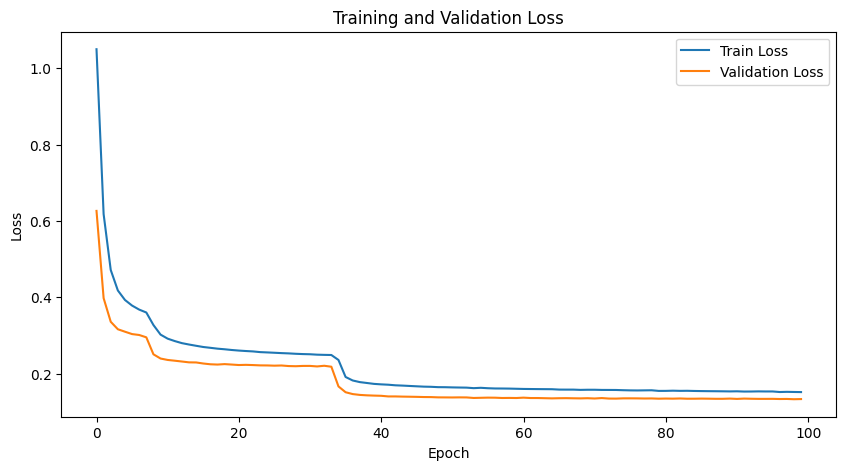

In [64]:
# Plot the training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [24]:
model = AutoEncode().to(device)

# Define the loss functions
loss = torch.nn.MSELoss()  # For classification

# Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

#scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.01)  # Learning rate decay scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=4)

# Variables for early stopping and best parameters
best_loss = float('inf')
best_custom_loss = float('inf')
patience_limit = 20


best_encoder_model = None
best_decoder_model = None


train_losses = []
val_losses = []


# Train the model
EPOCHS = 100
for epoch in range(EPOCHS):
    running_train_loss = 0.0
    running_train_custom_loss = 0.0
    
    model.train()
    progress_bar_train = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_train:
        # Forward pass
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)
        
        nn_output = model(main_channels_mat_for_nn)

        initial_loss = loss(nn_output, main_channels_mat_for_nn)
        train_custom_loss = l2_norm_square_loss(main_channels_mat_for_nn, nn_output)
        # Calculate loss
        
        train_loss = initial_loss + 0.01*train_custom_loss

        # Backward pass
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Update running loss
        running_train_loss += train_loss.item()
        running_train_custom_loss += train_custom_loss.item()

        
        avg_train_loss = running_train_loss / (index + 1)
        avg_train_custom_loss = running_train_custom_loss / (index + 1)

        # Get current learning rate from the optimizer
        current_lr = optimizer.param_groups[0]['lr']

        # Print metrics
        #progress_bar_train.set_description(f'Epoch [{epoch + 1}/{EPOCHS}] MSELos:{avg_train_loss1:.4f} MSEWeig{mse_weight:.2f} CELos:{avg_train_loss2:.4f} CEWeig{ce_weight:.2f} TrLos:{avg_train_loss:.4f} Tr.Acc: {avg_train_acc*100:.2f}%')
        progress_bar_train.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] T Loss:{avg_train_loss:.4f} Cus Loss:{avg_train_custom_loss:.4f}  LR is {current_lr:.6f}")
    
    #train_losses.append(avg_train_loss)
    train_losses.append(avg_train_loss)

    print(f"Training has completed epoch {epoch+1}")
    
    # Validation loop
    running_val_loss = 0.0
    running_val_custom_loss = 0.0

    
    model.eval()
    progress_bar_val = tqdm(enumerate(val_loader), total=len(val_loader), ncols=100)
    for index, (main_channels_mat) in progress_bar_val:
        
        #algorithm_output_mat_for_nn = (batch_complex_autocorrelation(algorithm_output_mat)).to(device)
        main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1).to(device)

        
        with torch.no_grad():
            
            nn_output = model(main_channels_mat_for_nn)

            # Calculate losses
            val_loss = loss(nn_output, main_channels_mat_for_nn)
            val_custom_loss = l2_norm_square_loss(main_channels_mat_for_nn, nn_output)

            # Update running loss
            running_val_loss += val_loss.item()
            running_val_custom_loss += val_custom_loss.item()
            
            avg_val_loss = running_val_loss / (index + 1)
            avg_val_custom_loss = running_val_custom_loss / (index + 1)
            
            progress_bar_val.set_description(f" Epoch [{epoch + 1}/{EPOCHS}] V Loss:{avg_val_loss:.4f} Custom Loss:{avg_val_custom_loss:.4f}")
    
    #val_losses.append(avg_val_loss)
    val_losses.append(avg_val_loss)
    
    scheduler.step(running_val_custom_loss)


    # Early stopping
    if avg_val_custom_loss < best_custom_loss:  # Now checking for the best accuracy
        best_loss = avg_val_loss
        best_custom_loss = avg_val_custom_loss
        best_epoch = epoch + 1
        patience_ = 0
        
        best_encoder_weights = copy.deepcopy(model.encoder.state_dict())
        best_decoder_weights = copy.deepcopy(model.decoder.state_dict())
        #print(f"Best Validation Loss is now: {best_loss:.4f} at Epoch: {best_epoch}")
        print(f"Best Validation Custom Loss is now: {best_custom_loss:.4f} at Epoch: {best_epoch}")
    else:
        patience_ += 1
        print(f"This is Epoch: {patience_} without improvement")
        #print(f"Current Validation Loss is: {avg_val_loss:.4f} at Epoch: {epoch+1}")
        #print(f"Best Validation Loss remains: {best_loss:.4f} at Epoch: {best_epoch}")
        print(f"Current Validation Custom Loss is: {avg_val_custom_loss:.4f} at Epoch: {epoch+1}")
        print(f"Best Validation Custom Loss remains: {best_custom_loss:.4f} at Epoch: {best_epoch}")
        if patience_ > patience_limit:  # Patience limit before stopping
            print("Early stopping triggered! Restoring best model weights.")
            #print(f"Best Validation Loss was: {best_loss:.4f} at Epoch: {best_epoch}")
            print(f"Best Validation Custom Loss was: {best_custom_loss:.4f} at Epoch: {best_epoch}")
            break

best_encoder_model = model.decoder.encoder.cpu()
best_encoder_model.load_state_dict(best_encoder_weights)

best_decoder_model = model.decoder.cpu()
best_decoder_model.load_state_dict(best_decoder_weights)


Epoch [1/100] T Loss:1.5750 Cus Loss:57.9934  LR is 0.001000: 100%|█| 2500/2500 [00:23<00:00, 108.6

Training has completed epoch 1



Epoch [1/100] V Loss:0.9913 Custom Loss:40.3099: 100%|██████████| 313/313 [00:01<00:00, 221.16it/s]

Best Validation Custom Loss is now: 40.3099 at Epoch: 1



Epoch [2/100] T Loss:1.1713 Cus Loss:17.5141  LR is 0.001000: 100%|█| 2500/2500 [00:22<00:00, 109.3

Training has completed epoch 2



Epoch [2/100] V Loss:0.9915 Custom Loss:6.0919: 100%|███████████| 313/313 [00:01<00:00, 231.23it/s]

Best Validation Custom Loss is now: 6.0919 at Epoch: 2



Epoch [3/100] T Loss:1.0547 Cus Loss:5.7633  LR is 0.001000: 100%|█| 2500/2500 [00:22<00:00, 110.46

Training has completed epoch 3



Epoch [3/100] V Loss:0.9987 Custom Loss:3.7333: 100%|███████████| 313/313 [00:01<00:00, 234.95it/s]

Best Validation Custom Loss is now: 3.7333 at Epoch: 3



Epoch [4/100] T Loss:1.0456 Cus Loss:4.8519  LR is 0.001000: 100%|█| 2500/2500 [00:22<00:00, 113.21

Training has completed epoch 4



Epoch [4/100] V Loss:0.9982 Custom Loss:3.0482: 100%|███████████| 313/313 [00:01<00:00, 210.54it/s]

Best Validation Custom Loss is now: 3.0482 at Epoch: 4



Epoch [5/100] T Loss:1.0369 Cus Loss:3.9859  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 113.68

Training has completed epoch 5



Epoch [5/100] V Loss:0.9972 Custom Loss:2.2217: 100%|███████████| 313/313 [00:01<00:00, 245.77it/s]

Best Validation Custom Loss is now: 2.2217 at Epoch: 5



Epoch [6/100] T Loss:1.0336 Cus Loss:3.6592  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 115.49

Training has completed epoch 6



Epoch [6/100] V Loss:0.9983 Custom Loss:1.8614: 100%|███████████| 313/313 [00:01<00:00, 218.25it/s]

Best Validation Custom Loss is now: 1.8614 at Epoch: 6



Epoch [7/100] T Loss:1.0311 Cus Loss:3.4134  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 115.10

Training has completed epoch 7



Epoch [7/100] V Loss:0.9978 Custom Loss:2.8227: 100%|███████████| 313/313 [00:01<00:00, 245.46it/s]

This is Epoch: 1 without improvement
Current Validation Custom Loss is: 2.8227 at Epoch: 7
Best Validation Custom Loss remains: 1.8614 at Epoch: 6



Epoch [8/100] T Loss:1.0302 Cus Loss:3.3277  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 115.31

Training has completed epoch 8



Epoch [8/100] V Loss:0.9962 Custom Loss:1.8737: 100%|███████████| 313/313 [00:01<00:00, 196.09it/s]

This is Epoch: 2 without improvement
Current Validation Custom Loss is: 1.8737 at Epoch: 8
Best Validation Custom Loss remains: 1.8614 at Epoch: 6



Epoch [9/100] T Loss:1.0287 Cus Loss:3.1705  LR is 0.001000: 100%|█| 2500/2500 [00:22<00:00, 112.20

Training has completed epoch 9



Epoch [9/100] V Loss:1.0003 Custom Loss:1.6091: 100%|███████████| 313/313 [00:01<00:00, 244.46it/s]

Best Validation Custom Loss is now: 1.6091 at Epoch: 9



Epoch [10/100] T Loss:1.0278 Cus Loss:3.0857  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 116.5

Training has completed epoch 10



Epoch [10/100] V Loss:0.9921 Custom Loss:2.3376: 100%|██████████| 313/313 [00:01<00:00, 244.88it/s]

This is Epoch: 1 without improvement
Current Validation Custom Loss is: 2.3376 at Epoch: 10
Best Validation Custom Loss remains: 1.6091 at Epoch: 9



Epoch [11/100] T Loss:1.0269 Cus Loss:3.0017  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 115.3

Training has completed epoch 11



Epoch [11/100] V Loss:0.9962 Custom Loss:1.5328: 100%|██████████| 313/313 [00:01<00:00, 244.08it/s]

Best Validation Custom Loss is now: 1.5328 at Epoch: 11



Epoch [12/100] T Loss:1.0265 Cus Loss:2.9637  LR is 0.001000: 100%|█| 2500/2500 [00:22<00:00, 112.6

Training has completed epoch 12



Epoch [12/100] V Loss:0.9981 Custom Loss:1.5542: 100%|██████████| 313/313 [00:01<00:00, 250.72it/s]

This is Epoch: 1 without improvement
Current Validation Custom Loss is: 1.5542 at Epoch: 12
Best Validation Custom Loss remains: 1.5328 at Epoch: 11



Epoch [13/100] T Loss:1.0260 Cus Loss:2.9265  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 114.9

Training has completed epoch 13



Epoch [13/100] V Loss:0.9972 Custom Loss:1.7454: 100%|██████████| 313/313 [00:01<00:00, 244.99it/s]

This is Epoch: 2 without improvement
Current Validation Custom Loss is: 1.7454 at Epoch: 13
Best Validation Custom Loss remains: 1.5328 at Epoch: 11



Epoch [14/100] T Loss:1.0252 Cus Loss:2.8528  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 114.7

Training has completed epoch 14



Epoch [14/100] V Loss:0.9965 Custom Loss:1.4627: 100%|██████████| 313/313 [00:01<00:00, 244.02it/s]

Best Validation Custom Loss is now: 1.4627 at Epoch: 14



Epoch [15/100] T Loss:1.0249 Cus Loss:2.8312  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 115.7

Training has completed epoch 15



Epoch [15/100] V Loss:0.9982 Custom Loss:1.0984: 100%|██████████| 313/313 [00:01<00:00, 250.46it/s]

Best Validation Custom Loss is now: 1.0984 at Epoch: 15



Epoch [16/100] T Loss:1.0247 Cus Loss:2.8118  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 114.4

Training has completed epoch 16



Epoch [16/100] V Loss:0.9989 Custom Loss:1.2367: 100%|██████████| 313/313 [00:01<00:00, 235.30it/s]

This is Epoch: 1 without improvement
Current Validation Custom Loss is: 1.2367 at Epoch: 16
Best Validation Custom Loss remains: 1.0984 at Epoch: 15



Epoch [17/100] T Loss:1.0240 Cus Loss:2.7440  LR is 0.001000: 100%|█| 2500/2500 [00:22<00:00, 112.3

Training has completed epoch 17



Epoch [17/100] V Loss:0.9962 Custom Loss:1.3253: 100%|██████████| 313/313 [00:01<00:00, 241.11it/s]

This is Epoch: 2 without improvement
Current Validation Custom Loss is: 1.3253 at Epoch: 17
Best Validation Custom Loss remains: 1.0984 at Epoch: 15



Epoch [18/100] T Loss:1.0242 Cus Loss:2.7769  LR is 0.001000: 100%|█| 2500/2500 [00:22<00:00, 112.8

Training has completed epoch 18



Epoch [18/100] V Loss:0.9949 Custom Loss:1.5979: 100%|██████████| 313/313 [00:01<00:00, 246.48it/s]

This is Epoch: 3 without improvement
Current Validation Custom Loss is: 1.5979 at Epoch: 18
Best Validation Custom Loss remains: 1.0984 at Epoch: 15



Epoch [19/100] T Loss:1.0236 Cus Loss:2.7269  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 114.1

Training has completed epoch 19



Epoch [19/100] V Loss:0.9953 Custom Loss:1.3673: 100%|██████████| 313/313 [00:01<00:00, 224.21it/s]

This is Epoch: 4 without improvement
Current Validation Custom Loss is: 1.3673 at Epoch: 19
Best Validation Custom Loss remains: 1.0984 at Epoch: 15



Epoch [20/100] T Loss:1.0236 Cus Loss:2.7296  LR is 0.001000: 100%|█| 2500/2500 [00:21<00:00, 114.7

Training has completed epoch 20



Epoch [20/100] V Loss:1.0016 Custom Loss:1.7254: 100%|██████████| 313/313 [00:01<00:00, 248.13it/s]

This is Epoch: 5 without improvement
Current Validation Custom Loss is: 1.7254 at Epoch: 20
Best Validation Custom Loss remains: 1.0984 at Epoch: 15



Epoch [21/100] T Loss:1.0224 Cus Loss:2.6182  LR is 0.000900: 100%|█| 2500/2500 [00:22<00:00, 111.7

Training has completed epoch 21



Epoch [21/100] V Loss:0.9981 Custom Loss:1.0204: 100%|██████████| 313/313 [00:01<00:00, 243.45it/s]

Best Validation Custom Loss is now: 1.0204 at Epoch: 21



Epoch [22/100] T Loss:1.0224 Cus Loss:2.6265  LR is 0.000900: 100%|█| 2500/2500 [00:22<00:00, 112.7

Training has completed epoch 22



Epoch [22/100] V Loss:0.9991 Custom Loss:1.4573: 100%|██████████| 313/313 [00:01<00:00, 186.29it/s]

This is Epoch: 1 without improvement
Current Validation Custom Loss is: 1.4573 at Epoch: 22
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [23/100] T Loss:1.0224 Cus Loss:2.6257  LR is 0.000900: 100%|█| 2500/2500 [00:22<00:00, 113.4

Training has completed epoch 23



Epoch [23/100] V Loss:0.9986 Custom Loss:1.2727: 100%|██████████| 313/313 [00:01<00:00, 232.81it/s]

This is Epoch: 2 without improvement
Current Validation Custom Loss is: 1.2727 at Epoch: 23
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [24/100] T Loss:1.0222 Cus Loss:2.6191  LR is 0.000900: 100%|█| 2500/2500 [00:25<00:00, 99.84

Training has completed epoch 24



Epoch [24/100] V Loss:0.9941 Custom Loss:1.5471: 100%|██████████| 313/313 [00:01<00:00, 203.93it/s]

This is Epoch: 3 without improvement
Current Validation Custom Loss is: 1.5471 at Epoch: 24
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [25/100] T Loss:1.0215 Cus Loss:2.5549  LR is 0.000900: 100%|█| 2500/2500 [00:23<00:00, 108.1

Training has completed epoch 25



Epoch [25/100] V Loss:0.9956 Custom Loss:1.4440: 100%|██████████| 313/313 [00:01<00:00, 182.66it/s]

This is Epoch: 4 without improvement
Current Validation Custom Loss is: 1.4440 at Epoch: 25
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [26/100] T Loss:1.0219 Cus Loss:2.5974  LR is 0.000900: 100%|█| 2500/2500 [00:21<00:00, 113.7

Training has completed epoch 26



Epoch [26/100] V Loss:0.9954 Custom Loss:1.3964: 100%|██████████| 313/313 [00:01<00:00, 236.72it/s]

This is Epoch: 5 without improvement
Current Validation Custom Loss is: 1.3964 at Epoch: 26
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [27/100] T Loss:1.0210 Cus Loss:2.5150  LR is 0.000810: 100%|█| 2500/2500 [00:22<00:00, 109.4

Training has completed epoch 27



Epoch [27/100] V Loss:0.9977 Custom Loss:1.0408: 100%|██████████| 313/313 [00:01<00:00, 242.11it/s]

This is Epoch: 6 without improvement
Current Validation Custom Loss is: 1.0408 at Epoch: 27
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [28/100] T Loss:1.0207 Cus Loss:2.4959  LR is 0.000810: 100%|█| 2500/2500 [00:22<00:00, 110.2

Training has completed epoch 28



Epoch [28/100] V Loss:0.9970 Custom Loss:1.1701: 100%|██████████| 313/313 [00:01<00:00, 244.89it/s]

This is Epoch: 7 without improvement
Current Validation Custom Loss is: 1.1701 at Epoch: 28
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [29/100] T Loss:1.0205 Cus Loss:2.4794  LR is 0.000810: 100%|█| 2500/2500 [00:23<00:00, 108.0

Training has completed epoch 29



Epoch [29/100] V Loss:0.9956 Custom Loss:1.4384: 100%|██████████| 313/313 [00:01<00:00, 242.68it/s]

This is Epoch: 8 without improvement
Current Validation Custom Loss is: 1.4384 at Epoch: 29
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [30/100] T Loss:1.0204 Cus Loss:2.4778  LR is 0.000810: 100%|█| 2500/2500 [00:22<00:00, 109.7

Training has completed epoch 30



Epoch [30/100] V Loss:0.9977 Custom Loss:1.1594: 100%|██████████| 313/313 [00:01<00:00, 226.61it/s]

This is Epoch: 9 without improvement
Current Validation Custom Loss is: 1.1594 at Epoch: 30
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [31/100] T Loss:1.0203 Cus Loss:2.4719  LR is 0.000810: 100%|█| 2500/2500 [00:22<00:00, 111.1

Training has completed epoch 31



Epoch [31/100] V Loss:0.9977 Custom Loss:1.0918: 100%|██████████| 313/313 [00:01<00:00, 229.92it/s]

This is Epoch: 10 without improvement
Current Validation Custom Loss is: 1.0918 at Epoch: 31
Best Validation Custom Loss remains: 1.0204 at Epoch: 21



Epoch [32/100] T Loss:1.0199 Cus Loss:2.4720  LR is 0.000729: 100%|█| 2500/2500 [00:22<00:00, 109.7

Training has completed epoch 32



Epoch [32/100] V Loss:0.9980 Custom Loss:0.9836: 100%|██████████| 313/313 [00:01<00:00, 224.28it/s]

Best Validation Custom Loss is now: 0.9836 at Epoch: 32



Epoch [33/100] T Loss:1.0193 Cus Loss:2.4763  LR is 0.000729: 100%|█| 2500/2500 [00:22<00:00, 111.3

Training has completed epoch 33



Epoch [33/100] V Loss:0.9956 Custom Loss:1.2530: 100%|██████████| 313/313 [00:01<00:00, 233.17it/s]

This is Epoch: 1 without improvement
Current Validation Custom Loss is: 1.2530 at Epoch: 33
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [34/100] T Loss:1.0183 Cus Loss:2.5106  LR is 0.000729: 100%|█| 2500/2500 [00:23<00:00, 107.2

Training has completed epoch 34



Epoch [34/100] V Loss:0.9942 Custom Loss:1.1674: 100%|██████████| 313/313 [00:01<00:00, 235.29it/s]

This is Epoch: 2 without improvement
Current Validation Custom Loss is: 1.1674 at Epoch: 34
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [35/100] T Loss:1.0161 Cus Loss:2.5672  LR is 0.000729: 100%|█| 2500/2500 [00:22<00:00, 110.5

Training has completed epoch 35



Epoch [35/100] V Loss:0.9907 Custom Loss:1.3603: 100%|██████████| 313/313 [00:01<00:00, 245.29it/s]

This is Epoch: 3 without improvement
Current Validation Custom Loss is: 1.3603 at Epoch: 35
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [36/100] T Loss:1.0133 Cus Loss:2.6968  LR is 0.000729: 100%|█| 2500/2500 [00:22<00:00, 112.9

Training has completed epoch 36



Epoch [36/100] V Loss:0.9844 Custom Loss:1.3557: 100%|██████████| 313/313 [00:01<00:00, 239.01it/s]

This is Epoch: 4 without improvement
Current Validation Custom Loss is: 1.3557 at Epoch: 36
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [37/100] T Loss:1.0079 Cus Loss:2.8863  LR is 0.000729: 100%|█| 2500/2500 [00:22<00:00, 108.9

Training has completed epoch 37



Epoch [37/100] V Loss:0.9741 Custom Loss:1.7653: 100%|██████████| 313/313 [00:01<00:00, 241.57it/s]

This is Epoch: 5 without improvement
Current Validation Custom Loss is: 1.7653 at Epoch: 37
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [38/100] T Loss:1.0016 Cus Loss:3.0133  LR is 0.000656: 100%|█| 2500/2500 [00:22<00:00, 109.8

Training has completed epoch 38



Epoch [38/100] V Loss:0.9655 Custom Loss:2.0696: 100%|██████████| 313/313 [00:01<00:00, 230.88it/s]

This is Epoch: 6 without improvement
Current Validation Custom Loss is: 2.0696 at Epoch: 38
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [39/100] T Loss:0.9958 Cus Loss:3.1743  LR is 0.000656: 100%|█| 2500/2500 [00:22<00:00, 112.0

Training has completed epoch 39



Epoch [39/100] V Loss:0.9617 Custom Loss:1.5876: 100%|██████████| 313/313 [00:01<00:00, 232.56it/s]

This is Epoch: 7 without improvement
Current Validation Custom Loss is: 1.5876 at Epoch: 39
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [40/100] T Loss:0.9901 Cus Loss:3.2200  LR is 0.000656: 100%|█| 2500/2500 [00:22<00:00, 113.0

Training has completed epoch 40



Epoch [40/100] V Loss:0.9553 Custom Loss:1.7604: 100%|██████████| 313/313 [00:01<00:00, 242.25it/s]

This is Epoch: 8 without improvement
Current Validation Custom Loss is: 1.7604 at Epoch: 40
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [41/100] T Loss:0.9855 Cus Loss:3.2820  LR is 0.000656: 100%|█| 2500/2500 [00:24<00:00, 103.7

Training has completed epoch 41



Epoch [41/100] V Loss:0.9498 Custom Loss:1.8587: 100%|██████████| 313/313 [00:01<00:00, 224.97it/s]

This is Epoch: 9 without improvement
Current Validation Custom Loss is: 1.8587 at Epoch: 41
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [42/100] T Loss:0.9807 Cus Loss:3.3123  LR is 0.000656: 100%|█| 2500/2500 [00:22<00:00, 109.2

Training has completed epoch 42



Epoch [42/100] V Loss:0.9464 Custom Loss:1.6978: 100%|██████████| 313/313 [00:01<00:00, 251.26it/s]

This is Epoch: 10 without improvement
Current Validation Custom Loss is: 1.6978 at Epoch: 42
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [43/100] T Loss:0.9758 Cus Loss:3.3228  LR is 0.000590: 100%|█| 2500/2500 [00:22<00:00, 113.1

Training has completed epoch 43



Epoch [43/100] V Loss:0.9421 Custom Loss:1.9063: 100%|██████████| 313/313 [00:01<00:00, 249.39it/s]

This is Epoch: 11 without improvement
Current Validation Custom Loss is: 1.9063 at Epoch: 43
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [44/100] T Loss:0.9716 Cus Loss:3.3521  LR is 0.000590: 100%|█| 2500/2500 [00:21<00:00, 114.9

Training has completed epoch 44



Epoch [44/100] V Loss:0.9374 Custom Loss:1.6876: 100%|██████████| 313/313 [00:01<00:00, 249.30it/s]

This is Epoch: 12 without improvement
Current Validation Custom Loss is: 1.6876 at Epoch: 44
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [45/100] T Loss:0.9675 Cus Loss:3.3646  LR is 0.000590: 100%|█| 2500/2500 [00:21<00:00, 115.6

Training has completed epoch 45



Epoch [45/100] V Loss:0.9291 Custom Loss:2.2591: 100%|██████████| 313/313 [00:01<00:00, 203.72it/s]

This is Epoch: 13 without improvement
Current Validation Custom Loss is: 2.2591 at Epoch: 45
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [46/100] T Loss:0.9640 Cus Loss:3.4043  LR is 0.000590: 100%|█| 2500/2500 [00:21<00:00, 115.1

Training has completed epoch 46



Epoch [46/100] V Loss:0.9279 Custom Loss:2.0198: 100%|██████████| 313/313 [00:01<00:00, 245.85it/s]

This is Epoch: 14 without improvement
Current Validation Custom Loss is: 2.0198 at Epoch: 46
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [47/100] T Loss:0.9607 Cus Loss:3.3785  LR is 0.000590: 100%|█| 2500/2500 [00:21<00:00, 114.4

Training has completed epoch 47



Epoch [47/100] V Loss:0.9259 Custom Loss:1.7365: 100%|██████████| 313/313 [00:01<00:00, 249.12it/s]

This is Epoch: 15 without improvement
Current Validation Custom Loss is: 1.7365 at Epoch: 47
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [48/100] T Loss:0.9573 Cus Loss:3.2960  LR is 0.000531: 100%|█| 2500/2500 [00:21<00:00, 114.3

Training has completed epoch 48



Epoch [48/100] V Loss:0.9247 Custom Loss:1.6613: 100%|██████████| 313/313 [00:01<00:00, 266.54it/s]

This is Epoch: 16 without improvement
Current Validation Custom Loss is: 1.6613 at Epoch: 48
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [49/100] T Loss:0.9549 Cus Loss:3.2992  LR is 0.000531: 100%|█| 2500/2500 [00:21<00:00, 116.2

Training has completed epoch 49



Epoch [49/100] V Loss:0.9219 Custom Loss:1.6919: 100%|██████████| 313/313 [00:01<00:00, 218.36it/s]

This is Epoch: 17 without improvement
Current Validation Custom Loss is: 1.6919 at Epoch: 49
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [50/100] T Loss:0.9524 Cus Loss:3.2725  LR is 0.000531: 100%|█| 2500/2500 [00:24<00:00, 100.9

Training has completed epoch 50



Epoch [50/100] V Loss:0.9189 Custom Loss:1.7573: 100%|██████████| 313/313 [00:01<00:00, 231.30it/s]

This is Epoch: 18 without improvement
Current Validation Custom Loss is: 1.7573 at Epoch: 50
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [51/100] T Loss:0.9503 Cus Loss:3.2785  LR is 0.000531: 100%|█| 2500/2500 [00:23<00:00, 106.3

Training has completed epoch 51



Epoch [51/100] V Loss:0.9198 Custom Loss:1.9189: 100%|██████████| 313/313 [00:01<00:00, 234.97it/s]

This is Epoch: 19 without improvement
Current Validation Custom Loss is: 1.9189 at Epoch: 51
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [52/100] T Loss:0.9484 Cus Loss:3.2656  LR is 0.000531: 100%|█| 2500/2500 [00:23<00:00, 104.7

Training has completed epoch 52



Epoch [52/100] V Loss:0.9148 Custom Loss:1.8852: 100%|██████████| 313/313 [00:01<00:00, 239.46it/s]

This is Epoch: 20 without improvement
Current Validation Custom Loss is: 1.8852 at Epoch: 52
Best Validation Custom Loss remains: 0.9836 at Epoch: 32



Epoch [53/100] T Loss:0.9464 Cus Loss:3.2125  LR is 0.000478: 100%|█| 2500/2500 [00:22<00:00, 112.0

Training has completed epoch 53



Epoch [53/100] V Loss:0.9160 Custom Loss:1.5280: 100%|██████████| 313/313 [00:01<00:00, 217.29it/s]

This is Epoch: 21 without improvement
Current Validation Custom Loss is: 1.5280 at Epoch: 53
Best Validation Custom Loss remains: 0.9836 at Epoch: 32
Early stopping triggered! Restoring best model weights.
Best Validation Custom Loss was: 0.9836 at Epoch: 32


<All keys matched successfully>

In [68]:
encoder_path = "best_encoder_with_power_loss.pth"
torch.save(best_encoder_model, encoder_path)

In [69]:
decoder_path = "best_decoder_with_power_loss.pth"
torch.save(best_decoder_model, decoder_path)

In [70]:
test_losses = []
running_test_loss = 0.0


progress_bar_test = tqdm(enumerate(test_loader), total=len(test_loader), ncols=100)
for index, (main_channels_mat) in progress_bar_test:
        
    main_channels_mat_for_nn = torch.stack([torch.real(main_channels_mat).float(), torch.imag(main_channels_mat).float()], dim=1)
    
    with torch.no_grad():
            
        nn_output_enc = best_encoder_model(main_channels_mat_for_nn)
        nn_output = best_decoder_model(nn_output_enc)

        # Calculate losses
        test_loss = loss(nn_output, main_channels_mat_for_nn)

        # Update running loss
        running_test_loss += test_loss.item()
            
        avg_test_loss = running_test_loss / (index + 1)

        progress_bar_test.set_description(f'Test Loss:{avg_test_loss:.4f}')

test_losses.append(avg_test_loss)


est Loss:0.7505: 100%|███████████████████████████████████████████| 313/313 [00:04<00:00, 67.47it/s]

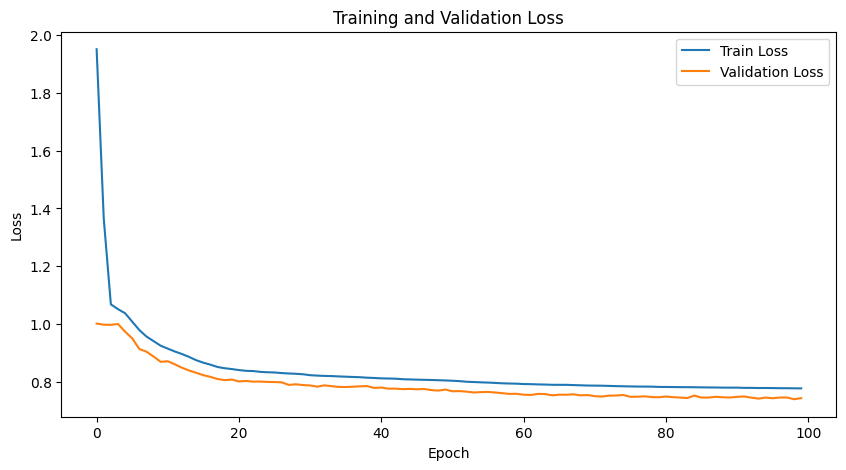

In [71]:
# Plot the training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
